In [1]:
#!/usr/bin/env python3
#import your libraries
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
import warnings
warnings.filterwarnings("ignore")
from catboost import CatBoostClassifier, Pool
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import binarize
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle
from xgboost import XGBClassifier

In [ ]:
# test test

In [2]:
train_transaction = pd.read_csv('/Users/krahman/work/fraud_detection/data/train_transaction.csv')
train_identity = pd.read_csv('/Users/krahman/work/fraud_detection/data/train_identity.csv')
# merging dataframes 
df_raw = train_transaction.merge(train_identity, on='TransactionID', how='left')
df_train = df_raw.copy()

### Assigning columns to specific lists (cat, num, date, etc.)

In [3]:
# dropping columns with more than 50% missing data
length_df = df_train.shape[0]/2
list_temp = []
for val in df_train.columns:
    if np.sum(df_train[val].isnull()) > length_df:
        list_temp.append(val)   
df_train = df_train.drop(list_temp, axis=1)

###################################
# c is num, ex, how many addresses associated with card
col_c = [c for c in df_train.columns if c.startswith('C') and (len(c)==2 or len(c)==3)]
# d is num, time/days between transactions
col_d = [d for d in df_train.columns if d.startswith('D') and (len(d)==2 or len(d)==3)]
# m is date of transaction
col_m = [m for m in df_train.columns if m.startswith('M') and (len(m)==2 or len(m)==3)]
# v is num, features created by vesta such as ranking, counting. entity relationships, etc. 
col_v = [v for v in df_train.columns if v.startswith('V') and (len(v)==2 or len(v)==3 or len(v)==4)]
# i is identity information like network and digital signature associated with transaction
col_i = [i for i in df_train.columns if i.startswith('id_') and len(i)==5]
# ca is cat, card information such as card type, etc. 
col_card = [ca for ca in df_train.columns if ca.startswith('card')]

# column id and target
col_id = ['TransactionID']
col_target = 'isFraud'

# converting categorical columns with numerical values to string types.
col_cat_to_obj = ['addr1','addr2','card1','card2', 'card3', 'card5']
for val in col_cat_to_obj:
    df_train[val] = df_train[val].astype(str)

# categorical columns
col_cat = ['addr1','addr2','ProductCD',"P_emaildomain"] + col_card + col_m

# C counter, D is time elapsed between transactions, V feature engineered variables by firm
col_num = ['TransactionAmt'] + col_c + col_d + col_v 
col_num.append(col_target)

# figure out how to handle this. What do these dates mean? Do certain dates have more fraud occurences?
col_date = ['TransactionDT'] 

# confirming all columns are accounted for
print('Total columns: ' + str(len(col_cat + col_num + col_date + col_id + col_i)))

Total columns: 220


In [ ]:
class Preprocessing:
    def __init__(self):
        '''initialize variables and column names for null dataframe'''
        self.df_train = df_train.copy()
        self.list_col = []
        self.list_total = []
        self.dict_unique = {}
        self.list_datatype = []
        self.list_unique_val = []
        self.list_mode_count = []
        self.list_mode_value = []
        self.list_mode_count_perc = []
        self.list_unique_total = []
        self.list_unique_first_10 = []
        self.column_names = ['col_name', 'total_null', 'datatype', 'total_unique',
                             'mode_value', 'mode_count', 'mode_percentage']

    def missing_values(self):
        '''check for null values and add to null dataframe if more than 0 nulls exist'''
        for val in df_train.columns:
            total_null = np.sum(df_train[val].isnull())
            if total_null > 0:
                self.list_col.append(val)
                self.list_total.append(total_null)
                self.list_datatype.append(df_train[val].dtype)
                self.list_unique_total.append(len(df_train[val].unique()))
                self.list_unique_val.append(df_train[val].unique())
                self.list_mode_value.append(df_train[val].mode()[0])
                val_counts = max(df_train[val].value_counts())
                self.list_mode_count.append(val_counts)
                self.list_mode_count_perc.append(val_counts/len(df_train))
                val_unique = df_train[val].unique()
                self._create_dict(val_unique, df_train, val)
        df_null_info = self._create_dataframe()
        df_null_info = self._create_df_unique(df_null_info)
        self._summary(df_null_info)
        self._fillna(df_null_info)
        return df_null_info
    
    def _create_dict(self, val_unique, df_train, val):
        '''create dictionary of unique values for each column'''
        if (len(val_unique) > 99) and isinstance(df_train[val], object):  
            self.dict_unique.update([(val,0)])
        if (len(val_unique) > 99) and not isinstance(df_train[val], object):
            self.dict_unique.update([(val,0)])
        if len(val_unique) < 100:
            self.dict_unique.update([(val, val_unique)])

    def _create_dataframe(self):
        '''create main dataframe'''
        df_null_info = pd.DataFrame()
        counter = -1
        for list_val in [self.list_col, self.list_total, self.list_datatype, self.list_unique_total,
                        self.list_mode_value, self.list_mode_count, self.list_mode_count_perc]:
            counter = counter + 1
            col_title = self.column_names[counter]
            df = pd.DataFrame(list_val, columns=[col_title])
            df_null_info = pd.concat([df_null_info, df], axis=1)
        return df_null_info
    
    def _summary(self, df_null_info):
        val = df_null_info.shape[0]
        print('There were ' + str(val) + ' columns with null values.')
    
    def _create_df_unique(self, df_null_info):
        '''create unique values dataframe'''
        series_unique = pd.Series(self.dict_unique)
        df_unique = pd.DataFrame(series_unique).reset_index()
        df_unique = df_unique.rename(columns={'index':'col_name', 0:'unique'})
        df_null_info = df_null_info.merge(df_unique, how='left', 
                                          left_on='col_name', right_on='col_name')
        df_null_info.to_csv('/Users/krahman/work/fraud_detection/saved_files/df_null_info.csv')
        return df_null_info
    
    def _fillna(self, df_null_info):
        '''fill null values of df_train with mode'''
        total_null_columns = sum(np.sum(self.df_train.isnull()))
        if total_null_columns > 0:
            for val in df_null_info.col_name:
                val_mode = self.df_train[val].mode()[0]
                self.df_train[val] = self.df_train[val].fillna(val_mode)
    
    def impute_features(self):
        df_temp = pp.df_train
        for val in col_cat:
            total_unique_val = pp.df_train[val].unique().shape[0]
            if len(df_temp[val].unique()) < 60:
                print('dummies encoded: ' + str(val) + ' unique ' + str(total_unique_val))
                df_dumm = pd.get_dummies(df_temp[val], prefix=val, drop_first=True)
                df_temp = df_temp.drop(val,axis=1)
                df_temp = pd.concat([df_temp, df_dumm], axis=1)
            else:
                le = LabelEncoder()
                df_temp[val] = le.fit_transform(df_temp[val])
                print('label encoded: ' + str(val) + ' unique ' + str(total_unique_val))
        print('new dataframe shape:' + str(df_temp.shape))
        return df_temp

pp = Preprocessing()
df_null_info = pp.missing_values()

In [112]:
pp.df_train = pp.impute_features()
pp.df_train.to_csv('/Users/krahman/work/fraud_detection/saved_files/df_imputed.csv')

In [4]:
df_features = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/df_imputed.csv')
df_features = df_features.drop('Unnamed: 0', axis=1)

## Splitting features dataframe

In [ ]:
# # create features, target and split the dataframe
# X = pp.df_train.drop(col_target, axis=1)
# X = X.drop(col_id, axis=1)
# y = pp.df_train[col_target]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=42)

In [ ]:
# X = df_features.drop(col_target, axis=1)
# X = X.drop(col_id, axis=1)
# y = df_features[col_target]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

### EDA

### Feature Engineering Class

In [469]:
class FeatureEngineering():
    '''create new features for columns without ordinal values'''
    def __init__(self):
        self.list_fraud_perc = []
        self.df_feat = df_features.copy()
        self.df_raw = df_raw.copy()
        self.len_df_feat = self.df_feat.shape[0]
        self.dict_all_feat = {}
        self.new_col = []
        self.col = []
        self.col_fe = []
        self.df_new_feat = pd.DataFrame()
        self.list_drop_col = []
        self.str_list_col_fe = []
        self.list_feat = []

    def feature_testing(self, bool_drop_col, list_feat):
        '''testing and scoring new potential features'''
        print("While running feature_testing, do not run final_features.")            
        if list_feat:
            for col in list_feat:
                self.col_fe = col
                bool_predict_proba = False
                if col in df_features.columns:
                    df_feat = self.create_test_feature(bool_drop_col, col)
                    if df_feat_1000:
                        df_feat = df_feat[0:1000]
                    df_feat = df_feat.drop(self.list_drop_col[-1], axis=1)
                    self._apply_df_transform(df_feat)
                    model_lr = LogisticRegression(random_state=42, n_jobs=-1)
                    self._convert_list_to_string(list_feat)
                    mod.create_df_score_model(model_lr)
                else:
                    print("\nColumn", col, "does not exist in dataframe.\n")
            self.col_fe = []
        self.list_drop_col = []
            
    def final_features(self, bool_drop_col, list_feat):
        '''creates final new features'''
        print('after running final_features, run create_final_df.')
        self.list_feat = list_feat
        df_feat = self.create_feature(bool_drop_col, list_feat)  
        if df_feat_1000:
            df_feat = df_feat[0:1000]
        for col in list_feat:
            col_fe = self._append_col_lists(col)
            df_feat[col] = self._fill_na(df_feat, col_fe)
            self._concat_df_new_feat(df_feat, col_fe)
        self._convert_list_to_string(list_feat)
        return df_feat
    
    def _append_col_lists(self, col):
        '''appending columns and new feature column names'''
        col_fe = col + '_fe'
        self.col.append(col)
        self.col_fe.append(col_fe)
        return col_fe

    def _fill_na(self, df_feat, col_fe):
        '''fill na values for new features'''
        col_mode = df_feat[col_fe].mode()[0]
        return df_feat[col_fe].fillna(col_mode)
        
    def _concat_df_new_feat(self, df_feat, col_fe):
        '''adding new feauture columns to one dataframe'''  
        df_temp = df_feat[col_fe]
        self.df_new_feat = pd.concat([self.df_new_feat, df_temp], axis=1)
    
    def _convert_list_to_string(self, list_feat):
        '''convert list to string to print later'''
        str_temp = ''
        for val in list_feat:
            str_temp = str_temp + val + ' '
        self.str_list_col_fe = str_temp

    def create_final_df(self):
        '''creates final dataframe after creating final_features'''
        df_feat = pd.concat([df_features, self.df_new_feat], axis=1)
        if df_feat_1000:
            df_feat = pd.concat([df_features[0:1000], self.df_new_feat], axis=1)
        print('dropping columns: ', self.list_drop_col)
        df_feat = df_feat.drop(self.list_drop_col, axis=1)
        self._apply_df_transform(df_feat)
        self._create_tuning_df(df_feat)
        self.list_drop_col = []
        self._final_df_summary()
        
    def _shuffle_df(self, X, y):
        '''shuffle dataframe'''
        y = pd.Series(y)
        X = pd.DataFrame(X)
        df_temp = pd.concat([X, y], keys=['features','target'], axis=1)
        df_temp = shuffle(df_temp).reset_index(drop=True)
        X = df_temp.features
        y = df_temp.target
        return X, y
        
    def _final_df_summary(self):
        print("final dataframe created.")
        print("To test a model use the mod.create_df_score_model(model_current)")
        print("method where, for example, model_current = LogisticRegression().")

    def _apply_df_transform(self, df_feat):
        '''create dataframe, apply pca, apply smote'''
        self.df_feat = df_feat
        X, y = self._drop_col_id_target(df_feat)
        X_train, X_test, y_train, y_test = self._split_dataframe(X, y)
        X_train, y_train = self._sampling_techniques(X_train, y_train)
        mod.X_train, mod.y_train = self._apply_pca(X_train, y_train)          # apply to train set
        mod.X_test , mod.y_test = self._apply_pca(X_test, y_test) 
#         self._convert_to_matrix() # delete if all models run successfully. 
        
    def _sampling_techniques(self, X_train, y_train):
        '''applying resampling techniques and shuffle'''
        X_train, y_train = self._apply_downsampling(X_train, y_train) # apply only train set
        X_train, y_train = self._apply_smote(X_train, y_train)
        X_train, y_train = self._shuffle_df(X_train, y_train)
        return X_train, y_train
    
    def _create_tuning_df(self, df_feat):
        '''whole dataframe used for model tuning'''
        if bool_create_tuning_df:
            print("creating tuning dataframe...")
            X, y = self._drop_col_id_target(df_feat)
            X, y = self._apply_downsampling(X, y)
            X, y = self._apply_smote(X, y)
            mod.X_features, mod.y_target = self._shuffle_df(X, y)
        else:
            print('bool_create_tuning_df set to false.')

    def _split_dataframe(self, X, y):
        '''splitting dataframe into training and test set'''
        X_train, X_test, y_train, y_test = train_test_split(X, 
                                                            y, 
                                                            test_size=0.1, 
                                                            random_state=42)
        return X_train, X_test, y_train, y_test
        
    def _drop_col_id_target(self, df_feat):
        '''dropping col id and target from features and creating target dataframe'''
        X = df_feat.drop(col_target, axis=1)
        X = X.drop(col_id, axis=1)
        y = df_feat[col_target]
        return X, y
    
    def _apply_downsampling(self, X, y):
        '''down sampling majority class'''
        if bool_apply_downsampling:
            len_y_one = len(y[y==1])
            X_col_names = X.columns
            sampler = RandomUnderSampler(random_state=42, ratio={0:95000, 1:len_y_one})
            X, y = sampler.fit_sample(X, y)
            X = self._apply_col_names(X, X_col_names)
            print("downsampling applied.")
            return X, y
        else:
            print("bool_apply_downsampling set to false.")
            return X, y
            
    def _apply_smote(self, X, y):
        '''applying smote to split training set'''
        if bool_apply_smote:
            X_col_names = X.columns
            sm = SMOTE(random_state=42, n_jobs=-1)
            X, y = sm.fit_sample(X, y)
            X = self._apply_col_names(X, X_col_names)
            print("smote applied.")
            return X, y
        else:
            print("bool_apply_smote set to false.")
            return X, y
        
    def _apply_col_names(self, X, X_col_names):
        '''adding column names back to dataset'''
        X = pd.DataFrame(X, columns=X_col_names)
        return X
    
    def _apply_pca(self, X, y):
        '''applying PCA and creating train and test set'''
        if bool_apply_pca:
            X = self._pca(X)
            print('pca applied to training set, then test set.')
            return X, y
        else:
            print("bool_apply_pca set to false.")
            return X, y

    def _pca(self, X):
        '''applying pca features dataframe'''
        scaled_X = StandardScaler().fit_transform(X)
        pca = PCA(n_components=250) #set value
        pcomponents = pca.fit_transform(scaled_X)
        X_pca = pd.DataFrame(data=pcomponents)
        return X_pca
        
    def _convert_to_matrix(self):
        '''converting X_test to matrix so columns match X_train'''
        if bool_apply_downsampling or bool_apply_smote:
            mod.X_test = pd.DataFrame(mod.X_test.values)
            
    def create_test_feature(self, bool_drop_col, col):
        '''creates correllated ratio to target column'''
        df_feat = df_features.copy()        
        df_feat = self._calculate_target_perc(col, df_feat) 
        df_feat = self._map_col(col, df_feat)
        df_feat = self._create_ratio(df_feat)
        df_feat = self._drop_column(bool_drop_col, col, df_feat)
        return df_feat
    
    def create_feature(self, bool_drop_col, list_col):
        '''creating new feature'''
        df_feat = self.df_feat       
        for col in list_col:
            df_feat = self._check_col_exist(col, df_feat)
            df_feat = self._calculate_target_perc(col, df_feat) 
            df_feat = self._map_col(col, df_feat)
            df_feat = self._create_ratio(df_feat)
            df_feat = self._drop_column(bool_drop_col, col, df_feat)
        return df_feat 
    
    def _check_col_exist(self, col, df_feat):
        '''recreates original column from original dataframe'''
        if col not in df_feat.columns:
            df_feat[col] = df_raw[col]
            df_feat[col] = self._fill_na(df_feat, col)
            df_feat[col] = self._label_encode(df_feat, col)
        return df_feat
    
    def _label_encode(self, df_feat, col):
        '''label encoding columns pulled from original df_raw'''
        le = LabelEncoder()
        df_feat[col] = le.fit_transform(df_feat[col])
        return df_feat[col]
    
    def _drop_column(self, bool_drop_col, col, df_feat):
        '''dropping or keeping columns'''
        if bool_drop_col:
            if (col in df_features.columns):    
                self.list_drop_col.append(col) 
        else:
            print("keeping original feature", col)
        return df_feat

    def aggregate_features(self, list_col, val_aggreg):
        for col in list_col:
            df_groupby = self.df_raw.groupby(col).mean()
            dict_aggreg_col = df_groupby[[val_aggreg]].to_dict()
            self.df_feat[col + '_fe'] = self.df_raw[col].map(dict_aggreg_col['TransactionAmt'])
            col_mode = self.df_feat[col + '_fe'].mode()[0]
            self.df_feat[col + '_fe'] = self.df_feat[col + '_fe'].fillna(col_mode)

    def _calculate_target_perc(self, col_val, df_feat):
        '''calculate fraud percentage for each column'''
        list_perc = []
        dict_feat = {}
        unique_col_values = df_feat[col_val].unique()
        for val in unique_col_values:
            list_perc = self._append_fraud_percentage(df_feat, col_val, val, list_perc)    
        self._create_dict(col_val, list_perc, unique_col_values)
        return df_feat
    
    def _append_fraud_percentage(self, df_feat, col_val, val, list_perc):
        '''calculating fraud percentage and adding to list'''
        fraud_total = df_feat[(df_feat[col_val]==val) 
                            & (df_feat[col_target]==1)].shape[0]
        non_fraud_total = df_feat[(df_feat[col_val]==val) 
                                & (df_feat[col_target]==0)].shape[0]
        if (non_fraud_total==0):
            list_perc.append(0)
        else: 
            list_perc.append(fraud_total/non_fraud_total)
        return list_perc

    def _create_dict(self, col_val, list_perc, unique_col_values):
        '''create dictionary for original values to new fraud percent values'''
        col_name = col_val + '_fraud_perc'
        series_perc = pd.Series(list_perc, name=col_name)
        series_col = pd.Series(unique_col_values, name=col_val)
        df_feat = pd.concat([series_col, series_perc], axis=1)
        df_feat = df_feat.sort_values(col_name, ascending=False) 
        dict_feat = df_feat.set_index(col_val).to_dict()
        self.dict_all_feat.update(dict_feat)

    def _map_col(self, col, df_feat):
        '''map dictionary values to new features'''
        dict_keys = self.dict_all_feat.keys()
        for val in dict_keys:
            df_feat[col + '_fe'] = df_feat[col].map(self.dict_all_feat[val])
            self.new_col.append(col + '_fe')
        return df_feat
            
    def _create_ratio(self, df_feat):
        '''finalize new features with ranking values'''
        for val in self.new_col:
            col_min_val = df_feat[df_feat[val] > 0][val].min()
            df_feat[val] = df_feat[val]/col_min_val
        self.new_col = []
        return df_feat
    
mod = Model()
fe = FeatureEngineering()

bool_predict_proba = False
bool_thres_cost = False
bool_apply_pca = False
bool_apply_smote = True
bool_apply_downsampling = True

bool_create_tuning_df = True
bool_drop_col = True
df_feat_1000 = False
fe.final_features(bool_drop_col, list_feat=['addr1','addr2','card2','card3','C1','P_emaildomain', 
                                            'card6', 'V294','V279','C14','V306','D2','D10'])
bool_drop_col = False
fe.final_features(bool_drop_col, list_feat=['card5', 'V317', 'V69', 'D1','D3','D4','D11'])
fe.list_drop_col.append('C4')
fe.create_final_df()


# testing - lines below are for testing
# df_feat_1000 = False
# fe.final_features(bool_drop_col, list_feat=['addr1'])
# fe.create_final_df()

# fe.feature_testing(bool_drop_col, list_feat=['addr1'])

# NEXT, we need to fix our tuning dataframe. method, decide how we are going to tune our model, then 
# we also need to decide how this effects our results. Should we tune on the hold outset? If we applied
# smote and undersampling, etc. how does this effect our outcome?
# pca did not work properly. 


after running final_features, run create_final_df.
after running final_features, run create_final_df.
keeping original feature card5
keeping original feature V317
keeping original feature V69
keeping original feature D1
keeping original feature D3
keeping original feature D4
keeping original feature D11
dropping columns:  ['addr1', 'addr2', 'card2', 'card3', 'C1', 'V294', 'V279', 'C14', 'V306', 'D2', 'D10', 'C4']
downsampling applied.
smote applied.
bool_apply_pca set to false.
bool_apply_pca set to false.
creating tuning dataframe...
downsampling applied.
smote applied.
final dataframe created.
To test a model use the mod.create_df_score_model(model_current)
method where, for example, model_current = LogisticRegression().


In [474]:
bool_predict_proba = False
model_current = LogisticRegression(random_state=42, n_jobs=-1)
mod.create_df_score_model(model_current)

Fitting model:
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=-1, penalty='l2', random_state=42,
                   solver='warn', tol=0.0001, verbose=0, warm_start=False)

roc auc score: 0.6981436381365214 

              precision    recall  f1-score   support

           0       0.99      0.61      0.75     56945
           1       0.07      0.79      0.13      2109

    accuracy                           0.61     59054
   macro avg       0.53      0.70      0.44     59054
weighted avg       0.95      0.61      0.73     59054


df_scores:

      feat_tested   fn     fp  precision    recall  roc_auc_score  \
120     addr1_fe  928   2481   0.322501  0.559981       0.758206   
121          NaN  496  24603   0.061527  0.764817       0.666384   
122  model score  364   3902   0.309014  0.827406       0.879442   
123          NaN  916  13612   0

In [472]:
# save data
mod.X_train = pd.DataFrame(mod.X_train)
mod.y_train = pd.DataFrame(mod.y_train)
mod.X_test = pd.DataFrame(mod.X_test)
mod.y_test = pd.DataFrame(mod.y_test)
mod.X_train.to_csv('/Users/krahman/work/fraud_detection/saved_files/X_train.csv')
mod.y_train.to_csv('/Users/krahman/work/fraud_detection/saved_files/y_train.csv')
mod.X_test.to_csv('/Users/krahman/work/fraud_detection/saved_files/X_test.csv')
mod.y_test.to_csv('/Users/krahman/work/fraud_detection/saved_files/y_test.csv')
mod.X_features = pd.DataFrame(mod.X_features)
mod.y_target = pd.DataFrame(mod.y_target)
mod.X_features.to_csv('/Users/krahman/work/fraud_detection/saved_files/X_features.csv')
mod.y_target.to_csv('/Users/krahman/work/fraud_detection/saved_files/y_target.csv')


In [473]:
#read data
mod.X_train = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/X_train.csv').drop('Unnamed: 0',axis=1)
mod.y_train = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/y_train.csv').drop('Unnamed: 0',axis=1)
mod.X_test = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/X_test.csv').drop('Unnamed: 0',axis=1)
mod.y_test = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/y_test.csv').drop('Unnamed: 0',axis=1)
mod.X_features = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/X_features.csv').drop('Unnamed: 0',axis=1)
mod.y_target = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/y_target.csv').drop('Unnamed: 0',axis=1)

# mod.X_features = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/X_features.csv').drop('Unnamed: 0', axis=1)
# mod.y_target = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/y_target.csv').drop('Unnamed: 0', axis=1)
# mod.X_features.info(memory_usage='deep')
# mod.y_target.info(memory_usage='deep')


### Testing Tuned Models

In [ ]:
# bool_predict_proba = True
# model_current = LogisticRegression(random_state=42, n_jobs=-1)
# mod.create_df_score_model(model_current)

In [97]:
# # testing LogisticRegression
# bool_predict_proba = False
# model_current =  LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=False,
#                                    intercept_scaling=0.1, l1_ratio=1e-06, max_iter=150,
#                                    multi_class='multinomial', n_jobs=-1, penalty='none',
#                                    random_state=42, solver='lbfgs', tol=1e-05, verbose=0,
#                                    warm_start=False)
# mod.create_df_score_model(model_current)


Fitting model:
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=0.1, l1_ratio=0.01, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='none',
                   random_state=42, solver='newton-cg', tol=1e-06, verbose=0,
                   warm_start=False)
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=0.1, l1_ratio=0.01, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='none',
                   random_state=42, solver='newton-cg', tol=1e-06, verbose=0,
                   warm_start=False)


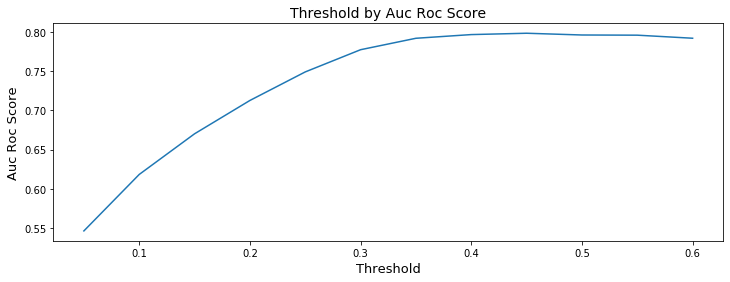

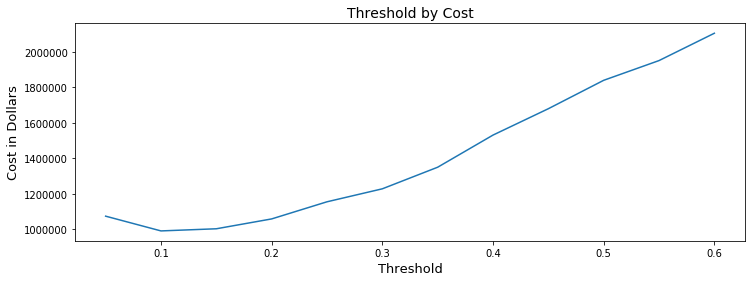

Best threshold by cost: 0.1
Best threshold by roc auc score: 0.45 

threshold results dataframe:
     threshold  roc_auc_score  total_cost   fn     fp
0        0.05       0.546106     1073240   16  51262
1        0.10       0.618236      990120   49  42156
2        0.15       0.670172     1002200  102  34810
3        0.20       0.712748     1057740  164  28287
4        0.25       0.749203     1154280  237  22164
5        0.30       0.777572     1227420  293  17421
6        0.35       0.792182     1349120  356  14056
7        0.40       0.796897     1530260  434  11413
8        0.45       0.798609     1678880  496   9544
9        0.50       0.796369     1838960  559   8098
10       0.55       0.796140     1950180  604   6909
11       0.60       0.792233     2104220  663   5761

roc auc score: 0.7986085664667492 

              precision    recall  f1-score   support

           0       0.99      0.83      0.90     56945
           1       0.14      0.76      0.24      2109

    accuracy

In [475]:
# testing LogisticRegression
bool_predict_proba = True
model_current =  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                                   intercept_scaling=0.1, l1_ratio=0.01, max_iter=100,
                                   multi_class='auto', n_jobs=-1, penalty='none',
                                   random_state=42, solver='newton-cg', tol=1e-06, verbose=0,
                                   warm_start=False)
mod.create_df_score_model(model_current)

Fitting model:
 XGBClassifier(base_score=0.4, booster='gbtree', colsample_bylevel=0.3,
              colsample_bynode=0.5, colsample_bytree=0.7, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=13,
              min_child_weight=1, missing=None, n_estimators=150, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=3, reg_lambda=5, scale_pos_weight=5, seed=None,
              silent=None, subsample=0.5, verbosity=1)

roc auc score: 0.879442047701356 


The following new features have been created: ['addr1_fe', 'addr2_fe', 'card2_fe', 'card3_fe', 'C1_fe', 'P_emaildomain_fe', 'card6_fe', 'V294_fe', 'V279_fe', 'C14_fe', 'V306_fe', 'D2_fe', 'D10_fe', 'card5_fe', 'V317_fe', 'V69_fe', 'D1_fe', 'D3_fe', 'D4_fe', 'D11_fe'] 

              precision    recall  f1-score   support

           0       0.99      0.93      0.96     56945
           1       0.31      0.83      0.45      2109

    accuracy                    

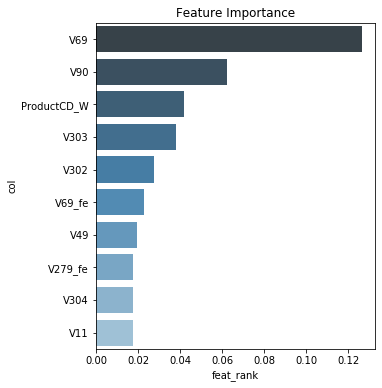

                              col  feat_rank
88                            V69   0.126292
109                           V90   0.062272
200                   ProductCD_W   0.042021
179                          V303   0.038131
178                          V302   0.027451
286                        V69_fe   0.022642
68                            V49   0.019730
279                       V279_fe   0.017665
180                          V304   0.017494
30                            V11   0.017442
157                          V280   0.014305
263                   card6_debit   0.014021
48                            V29   0.011675
116                           V97   0.010341
49                            V30   0.010190
281                       V306_fe   0.009638
280                        C14_fe   0.009559
76                            V57   0.008296
278                       V294_fe   0.007685
198                   ProductCD_R   0.007658
273                      card2_fe   0.007631
275       

In [470]:
# TESTING XGBClassifier n_estimators=150
bool_predict_proba = False
model_current = XGBClassifier(base_score=0.4, booster='gbtree', colsample_bylevel=0.3,
                              colsample_bynode=0.5, colsample_bytree=0.7, gamma=0,
                              learning_rate=0.1, max_delta_step=0, max_depth=13,
                              min_child_weight=1, missing=None, n_estimators=150, n_jobs=-1,
                              nthread=None, objective='binary:logistic', random_state=42,
                              reg_alpha=3, reg_lambda=5, scale_pos_weight=5, seed=None,
                              silent=None, subsample=0.5, verbosity=1)
mod.create_df_score_model(model_current)

Fitting model:
 XGBClassifier(base_score=0.4, booster='gbtree', colsample_bylevel=0.3,
              colsample_bynode=0.5, colsample_bytree=0.7, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=13,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=3, reg_lambda=5, scale_pos_weight=5, seed=None,
              silent=None, subsample=0.5, verbosity=1)
XGBClassifier(base_score=0.4, booster='gbtree', colsample_bylevel=0.3,
              colsample_bynode=0.5, colsample_bytree=0.7, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=13,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=3, reg_lambda=5, scale_pos_weight=5, seed=None,
              silent=None, subsample=0.5, verbosity=1)


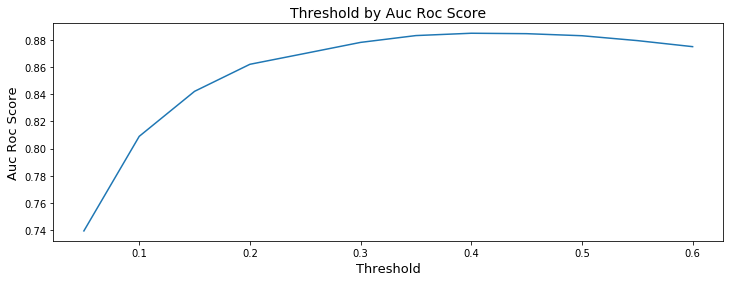

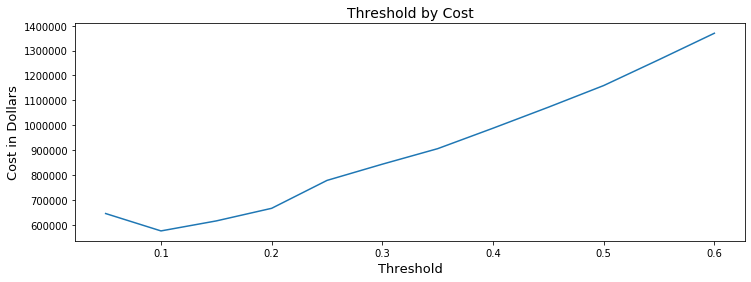

Best threshold by cost: 0.1
Best threshold by roc auc score: 0.4 

threshold results dataframe:
     threshold  roc_auc_score  total_cost   fn     fp
0        0.05       0.739415      645220   21  29111
1        0.10       0.808964      575360   57  20218
2        0.15       0.842066      615580  104  15179
3        0.20       0.861953      666220  143  11861
4        0.25       0.869978      778320  196   9516
5        0.30       0.878065      843540  230   7677
6        0.35       0.883078      905920  260   6296
7        0.40       0.884790      988120  295   5156
8        0.45       0.884474     1072480  329   4274
9        0.50       0.882963     1159560  363   3528
10       0.55       0.879380     1263660  402   2883
11       0.60       0.874928     1369740  441   2337

roc auc score: 0.8847898871416485 

              precision    recall  f1-score   support

           0       0.99      0.91      0.95     56945
           1       0.26      0.86      0.40      2109

    accuracy 

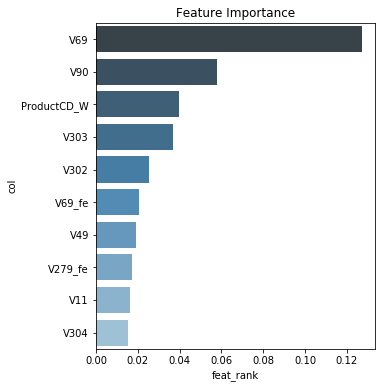

                              col  feat_rank
88                            V69   0.127120
109                           V90   0.058058
200                   ProductCD_W   0.039568
179                          V303   0.036627
178                          V302   0.025528
286                        V69_fe   0.020608
68                            V49   0.019144
279                       V279_fe   0.017154
30                            V11   0.016248
180                          V304   0.015380
157                          V280   0.013468
263                   card6_debit   0.012194
49                            V30   0.010490
48                            V29   0.010324
280                        C14_fe   0.009772
116                           V97   0.009629
281                       V306_fe   0.009165
198                   ProductCD_R   0.008684
76                            V57   0.008648
9                              C8   0.008110
275                         C1_fe   0.007607
278       

In [476]:
# testing XGBClassifier 200 n_estimators
model_current = XGBClassifier(base_score=0.4, booster='gbtree', colsample_bylevel=0.3,
                              colsample_bynode=0.5, colsample_bytree=0.7, gamma=0,
                              learning_rate=0.1, max_delta_step=0, max_depth=13,
                              min_child_weight=1, missing=None, n_estimators=200, n_jobs=-1,
                              nthread=None, objective='binary:logistic', random_state=42,
                              reg_alpha=3, reg_lambda=5, scale_pos_weight=5, seed=None,
                              silent=None, subsample=0.5, verbosity=1)
mod.create_df_score_model(model_current)


Fitting model:
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=9,
                       min_impurity_decrease=0.1, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=3,
                       min_weight_fraction_leaf=0.3, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.7s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=9,
                       min_impurity_decrease=0.1, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=3,
                       min_weight_fraction_leaf=0.3, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


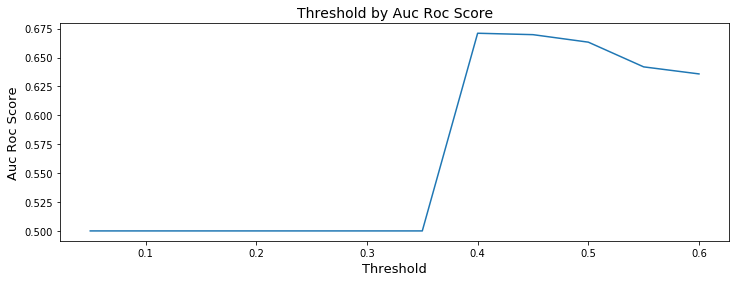

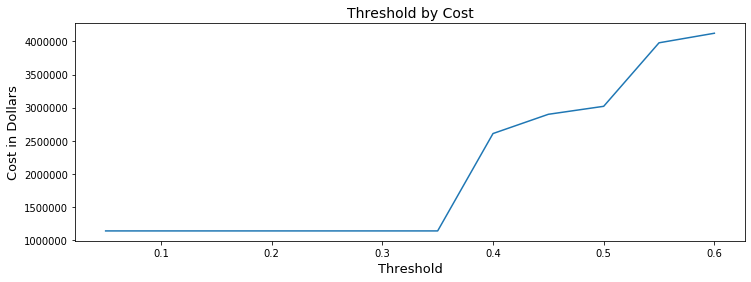

Best threshold by cost: 0.05
Best threshold by roc auc score: 0.4 

threshold results dataframe:
     threshold  roc_auc_score  total_cost    fn     fp
0        0.05       0.500000     1138900     0  56945
1        0.10       0.500000     1138900     0  56945
2        0.15       0.500000     1138900     0  56945
3        0.20       0.500000     1138900     0  56945
4        0.25       0.500000     1138900     0  56945
5        0.30       0.500000     1138900     0  56945
6        0.35       0.500000     1138900     0  56945
7        0.40       0.671027     2609080   756  17054
8        0.45       0.669806     2899680   873  14034
9        0.50       0.663317     3020240   916  13612
10       0.55       0.641933     3979140  1286   6057
11       0.60       0.635839     4123400  1339   5320

roc auc score: 0.6710271584208116 

              precision    recall  f1-score   support

           0       0.98      0.70      0.82     56945
           1       0.07      0.64      0.13      2109


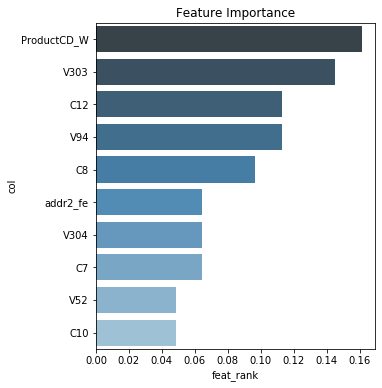

                               col  feat_rank
200                    ProductCD_W   0.161290
179                           V303   0.145161
13                             C12   0.112903
113                            V94   0.112903
9                               C8   0.096774
272                       addr2_fe   0.064516
180                           V304   0.064516
8                               C7   0.064516
71                             V52   0.048387
11                             C10   0.048387
274                       card3_fe   0.032258
53                             V34   0.016129
178                           V302   0.016129
273                       card2_fe   0.016129
191                           V316   0.000000
192                           V317   0.000000
193                           V318   0.000000
190                           V315   0.000000
194                           V319   0.000000
195                           V320   0.000000
196                           V321

In [477]:
# RETUNE testing RandomForestClassifier
model_current = RandomForestClassifier(bootstrap=True, class_weight=None,
                                       criterion='gini', max_depth=5, max_features='auto',
                                       max_leaf_nodes=9,
                                       min_impurity_decrease=0.1, min_impurity_split=None,
                                       min_samples_leaf=4, min_samples_split=3,
                                       min_weight_fraction_leaf=0.3, n_estimators=100,
                                       n_jobs=-1, oob_score=False, random_state=42, verbose=1,
                                       warm_start=False)
mod.create_df_score_model(model_current)


Fitting model:
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=9,
                       min_impurity_decrease=0.1, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=3,
                       min_weight_fraction_leaf=0.3, n_estimators=150,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    7.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=9,
                       min_impurity_decrease=0.1, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=3,
                       min_weight_fraction_leaf=0.3, n_estimators=150,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.2s finished


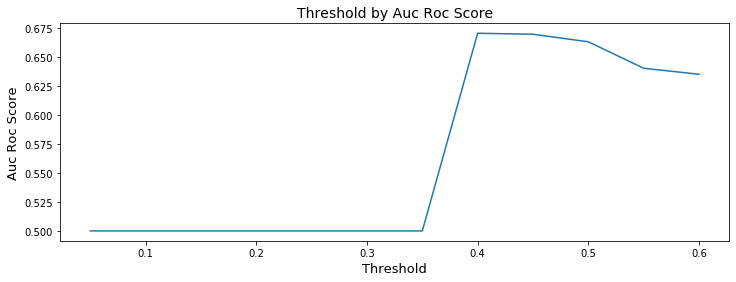

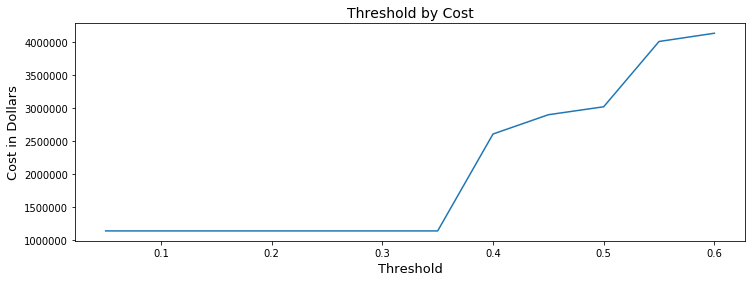

Best threshold by cost: 0.05
Best threshold by roc auc score: 0.4 

threshold results dataframe:
     threshold  roc_auc_score  total_cost    fn     fp
0        0.05       0.500000     1138900     0  56945
1        0.10       0.500000     1138900     0  56945
2        0.15       0.500000     1138900     0  56945
3        0.20       0.500000     1138900     0  56945
4        0.25       0.500000     1138900     0  56945
5        0.30       0.500000     1138900     0  56945
6        0.35       0.500000     1138900     0  56945
7        0.40       0.670667     2607440   755  17122
8        0.45       0.669806     2899680   873  14034
9        0.50       0.663290     3020300   916  13615
10       0.55       0.640449     4009580  1297   5929
11       0.60       0.635251     4134580  1343   5279

roc auc score: 0.6706671702595748 

              precision    recall  f1-score   support

           0       0.98      0.70      0.82     56945
           1       0.07      0.64      0.13      2109


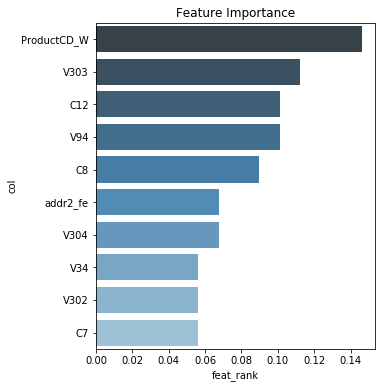

                               col  feat_rank
200                    ProductCD_W   0.146067
179                           V303   0.112360
13                             C12   0.101124
113                            V94   0.101124
9                               C8   0.089888
272                       addr2_fe   0.067416
180                           V304   0.067416
53                             V34   0.056180
178                           V302   0.056180
8                               C7   0.056180
11                             C10   0.044944
274                       card3_fe   0.033708
273                       card2_fe   0.033708
71                             V52   0.033708
191                           V316   0.000000
192                           V317   0.000000
193                           V318   0.000000
190                           V315   0.000000
194                           V319   0.000000
195                           V320   0.000000
196                           V321

In [478]:
# testing RandomForestClassifier n_estimators=150
model_current = RandomForestClassifier(bootstrap=True, class_weight=None,
                                       criterion='gini', max_depth=5, max_features='auto',
                                       max_leaf_nodes=9,
                                       min_impurity_decrease=0.1, min_impurity_split=None,
                                       min_samples_leaf=4, min_samples_split=3,
                                       min_weight_fraction_leaf=0.3, n_estimators=150,
                                       n_jobs=-1, oob_score=False, random_state=42, verbose=1,
                                       warm_start=False)
mod.create_df_score_model(model_current)


Fitting model:
 DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=11, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=9, min_samples_split=5,
                       min_weight_fraction_leaf=0, presort='auto',
                       random_state=42, splitter='best')
DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=11, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=9, min_samples_split=5,
                       min_weight_fraction_leaf=0, presort='auto',
                       random_state=42, splitter='best')


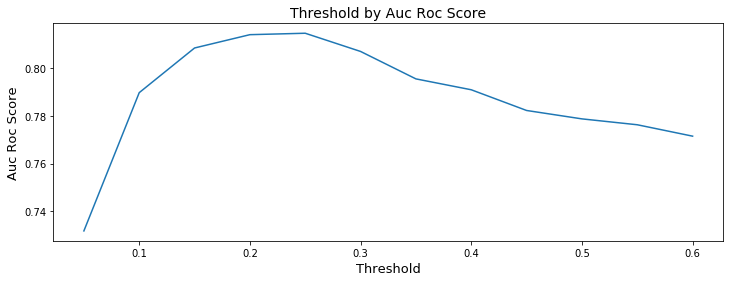

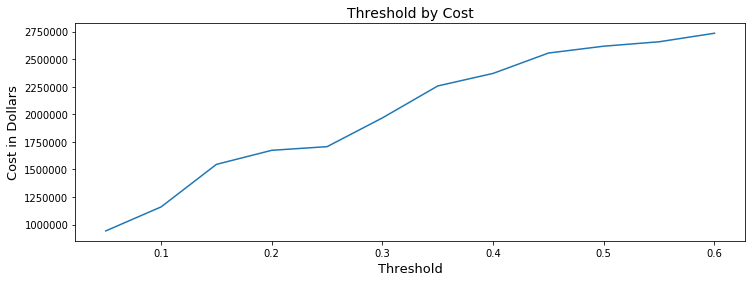

Best threshold by cost: 0.05
Best threshold by roc auc score: 0.25 

threshold results dataframe:
     threshold  roc_auc_score  total_cost   fn     fp
0        0.05       0.731828      942940  135  26897
1        0.10       0.789628     1160600  277  16480
2        0.15       0.808303     1546100  451   9655
3        0.20       0.813869     1673640  508   7482
4        0.25       0.814466     1706720  522   7036
5        0.30       0.806852     1967600  621   5230
6        0.35       0.795384     2256940  728   3647
7        0.40       0.790836     2370620  770   3031
8        0.45       0.782178     2555160  837   2208
9        0.50       0.778665     2617280  859   2014
10       0.55       0.776207     2657320  873   1916
11       0.60       0.771439     2734600  900   1730

roc auc score: 0.8144657562442961 

              precision    recall  f1-score   support

           0       0.99      0.88      0.93     56945
           1       0.18      0.75      0.30      2109

    accurac

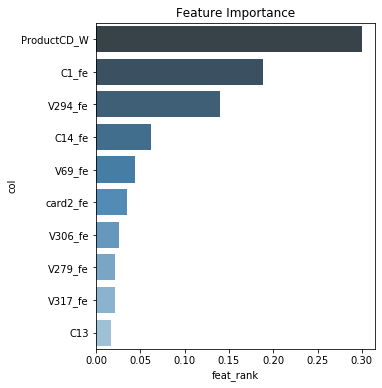

                             col  feat_rank
200                  ProductCD_W   0.299810
275                        C1_fe   0.188458
278                      V294_fe   0.140255
280                       C14_fe   0.061730
286                       V69_fe   0.044080
273                     card2_fe   0.035400
281                      V306_fe   0.025616
279                      V279_fe   0.021235
285                      V317_fe   0.021186
14                           C13   0.017006
263                  card6_debit   0.013329
88                           V69   0.013034
282                        D2_fe   0.012241
262                 card6_credit   0.010062
0                  TransactionDT   0.005920
117                          V98   0.005777
157                         V280   0.005342
1                 TransactionAmt   0.005318
283                       D10_fe   0.004886
158                         V281   0.003497
290                       D11_fe   0.003326
271                     addr1_fe

In [479]:
# testing DecisionTreeClassifier max_depth=11
model_current = DecisionTreeClassifier(class_weight='balanced',
                                       criterion='entropy', max_depth=11, max_features=None,
                                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                                       min_impurity_split=None, min_samples_leaf=9,
                                       min_samples_split=5, min_weight_fraction_leaf=0,
                                       presort='auto', random_state=42, splitter='best')

mod.create_df_score_model(model_current)

Fitting model:
 DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=13, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=9, min_samples_split=5,
                       min_weight_fraction_leaf=0, presort='auto',
                       random_state=42, splitter='best')
DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=13, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=9, min_samples_split=5,
                       min_weight_fraction_leaf=0, presort='auto',
                       random_state=42, splitter='best')


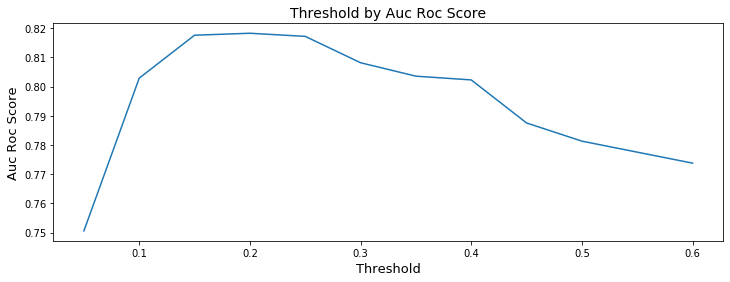

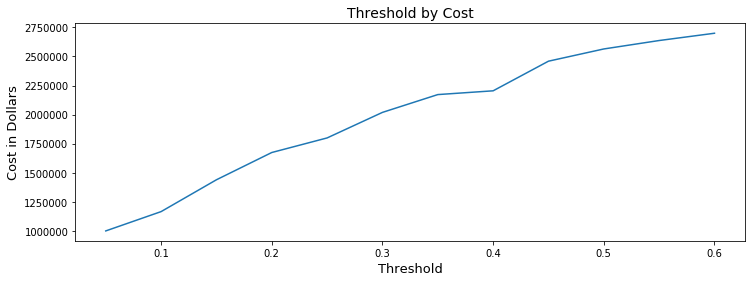

Best threshold by cost: 0.05
Best threshold by roc auc score: 0.2 

threshold results dataframe:
     threshold  roc_auc_score  total_cost   fn     fp
0        0.05       0.750547      998700  175  23685
1        0.10       0.802886     1164840  291  14592
2        0.15       0.817592     1438840  416   9542
3        0.20       0.818268     1673460  512   6873
4        0.25       0.817196     1798900  562   5645
5        0.30       0.808160     2018740  643   4487
6        0.35       0.803559     2171900  701   3445
7        0.40       0.802277     2204340  713   3267
8        0.45       0.787525     2459340  803   2517
9        0.50       0.781300     2564540  840   2227
10       0.55       0.777524     2637100  866   1955
11       0.60       0.773766     2699780  888   1789

roc auc score: 0.8182677536379862 

              precision    recall  f1-score   support

           0       0.99      0.88      0.93     56945
           1       0.19      0.76      0.30      2109

    accuracy

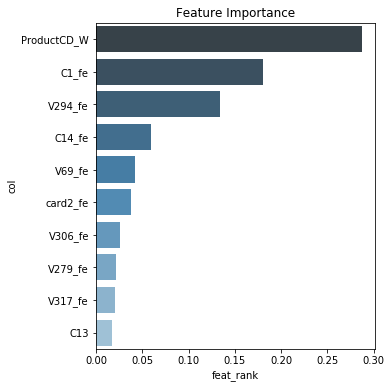

                             col  feat_rank
200                  ProductCD_W   0.287072
275                        C1_fe   0.180950
278                      V294_fe   0.134429
280                       C14_fe   0.059769
286                       V69_fe   0.042207
273                     card2_fe   0.037437
281                      V306_fe   0.025849
279                      V279_fe   0.021462
285                      V317_fe   0.020395
14                           C13   0.017218
88                           V69   0.012480
263                  card6_debit   0.012393
282                        D2_fe   0.012093
277                     card6_fe   0.009176
0                  TransactionDT   0.008210
1                 TransactionAmt   0.007228
117                          V98   0.005547
157                         V280   0.005257
283                       D10_fe   0.005160
271                     addr1_fe   0.004333
216      P_emaildomain_gmail.com   0.003799
290                       D11_fe

In [480]:
# testing DecisionTreeClassifier max_depth=13
model_current = DecisionTreeClassifier(class_weight='balanced',
                                       criterion='entropy', max_depth=13, max_features=None,
                                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                                       min_impurity_split=None, min_samples_leaf=9,
                                       min_samples_split=5, min_weight_fraction_leaf=0,
                                       presort='auto', random_state=42, splitter='best')

mod.create_df_score_model(model_current)

# NEXT, Create read me and presentation!

Fitting model:
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=-1, penalty='l2', random_state=42,
                   solver='warn', tol=0.0001, verbose=0, warm_start=False)
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=-1, penalty='l2', random_state=42,
                   solver='warn', tol=0.0001, verbose=0, warm_start=False)


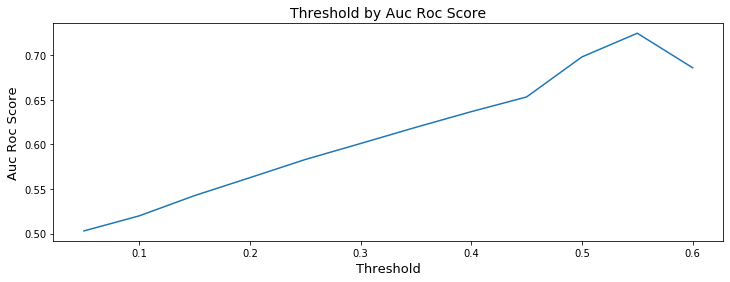

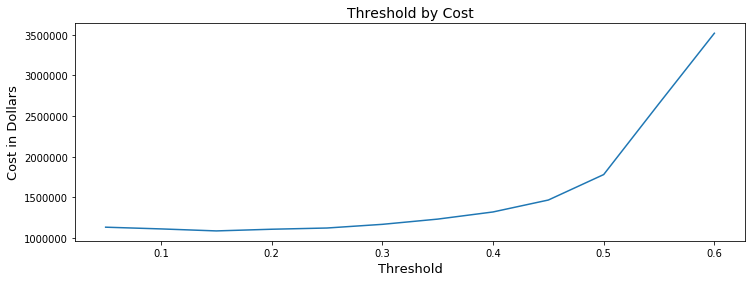

Best threshold by cost: 0.15
Best threshold by roc auc score: 0.55 

threshold results dataframe:
     threshold  roc_auc_score  total_cost    fn     fp
0        0.05       0.503056     1131940     0  56597
1        0.10       0.519940     1110700     7  54485
2        0.15       0.542655     1086020    18  51601
3        0.20       0.562753     1106660    45  48583
4        0.25       0.583123     1121760    70  45588
5        0.30       0.601070     1166980   105  42599
6        0.35       0.619245     1231360   148  39368
7        0.40       0.636779     1319340   200  35967
8        0.45       0.653251     1466320   275  32066
9        0.50       0.698144     1779800   444  22390
10       0.55       0.724692     2654120   824   9106
11       0.60       0.686012     3519580  1140   4979

roc auc score: 0.7246924101063136 

              precision    recall  f1-score   support

           0       0.98      0.84      0.91     56945
           1       0.12      0.61      0.21      2109

In [481]:
# base score LogisticRegression threshold
bool_predict_proba = True
model_current = LogisticRegression(random_state=42, n_jobs=-1)
mod.create_df_score_model(model_current)
bool_predict_proba = False


In [482]:
# base model LogisticRegression
model_current = LogisticRegression(random_state=42, n_jobs=-1)
mod.create_df_score_model(model_current)

Fitting model:
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=-1, penalty='l2', random_state=42,
                   solver='warn', tol=0.0001, verbose=0, warm_start=False)

roc auc score: 0.6981436381365214 

              precision    recall  f1-score   support

           0       0.99      0.61      0.75     56945
           1       0.07      0.79      0.13      2109

    accuracy                           0.61     59054
   macro avg       0.53      0.70      0.44     59054
weighted avg       0.95      0.61      0.73     59054


df_scores:

     feat_tested   fn     fp  precision    recall  roc_auc_score  \
128         NaN  755  17122   0.073284  0.642010       0.670667   
129         NaN  522   7036   0.184043  0.752489       0.814466   
130         NaN  512   6873   0.188548  0.757231       0.818268   
131         NaN  824   9106   0.1236

Fitting model:
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

roc auc score: 0.8050608048052489 

              precision    recall  f1-score   support

           0       0.99      0.92      0.95     56945
           1       0.25      0.69      0.36      2109

    accuracy                           0.91     59054
   macro avg       0.62      0.81      0.66     59054
weighted avg       0.96      0.91      0.93     59054


df_scores:

     feat_tested   fn     fp  precision    recall  roc_auc_score  \
129         NaN  522   7036   0.184043  0.752489       0.814466   
130         NaN  512   6873   0.188548  0.757231       0.818268   
13

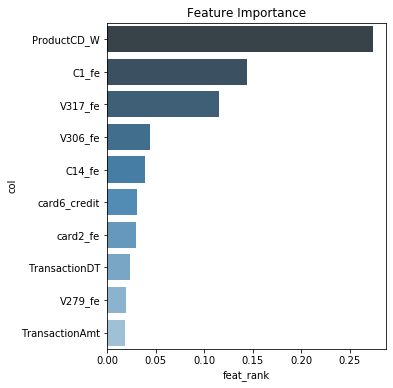

                             col  feat_rank
200                  ProductCD_W   0.273739
275                        C1_fe   0.143984
285                      V317_fe   0.115350
281                      V306_fe   0.044271
280                       C14_fe   0.038829
262                 card6_credit   0.031173
273                     card2_fe   0.029698
0                  TransactionDT   0.023893
279                      V279_fe   0.019579
1                 TransactionAmt   0.018191
286                       V69_fe   0.015444
278                      V294_fe   0.014769
2                          card1   0.012485
14                           C13   0.012108
271                     addr1_fe   0.009984
159                         V282   0.008406
7                             C6   0.007214
157                         V280   0.005464
289                        D4_fe   0.005404
282                        D2_fe   0.005035
162                         V285   0.004561
290                       D11_fe

In [483]:
# base DecisionTreeClassifier
bool_predict_proba = False
model_current = DecisionTreeClassifier(random_state=42)
mod.create_df_score_model(model_current)


Fitting model:
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    2.2s finished


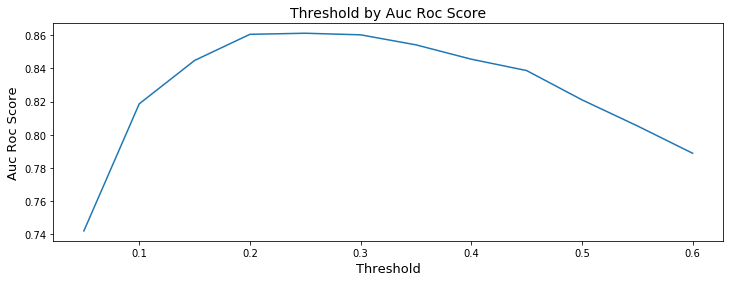

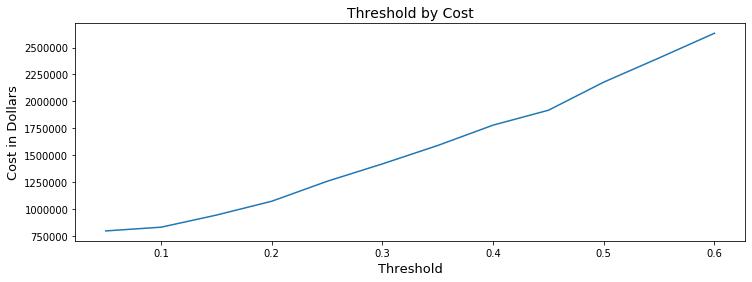

Best threshold by cost: 0.05
Best threshold by roc auc score: 0.25 

threshold results dataframe:
     threshold  roc_auc_score  total_cost   fn     fp
0        0.05       0.742049      794200   84  27110
1        0.10       0.818631      828860  169  16093
2        0.15       0.844787      941480  239  11224
3        0.20       0.860547     1070400  306   7620
4        0.25       0.861196     1255880  382   5494
5        0.30       0.860247     1417940  447   3847
6        0.35       0.854206     1589140  511   2807
7        0.40       0.845557     1778580  580   1929
8        0.45       0.838708     1917180  630   1359
9        0.50       0.821067     2178760  720    938
10       0.55       0.805376     2403920  797    646
11       0.60       0.788859     2633420  875    421

roc auc score: 0.8611962221705696 

              precision    recall  f1-score   support

           0       0.99      0.90      0.95     56945
           1       0.24      0.82      0.37      2109

    accurac

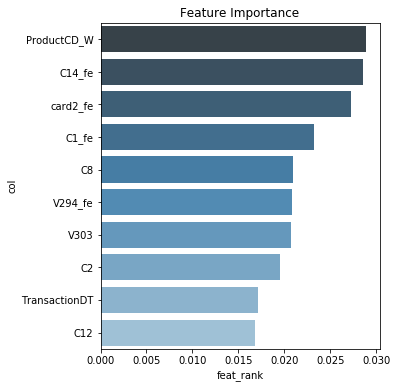

                  col  feat_rank
200       ProductCD_W   0.028936
280            C14_fe   0.028599
273          card2_fe   0.027242
275             C1_fe   0.023286
9                  C8   0.020971
278           V294_fe   0.020826
179              V303   0.020790
4                  C2   0.019499
0       TransactionDT   0.017108
13                C12   0.016862
285           V317_fe   0.016083
14                C13   0.015985
12                C11   0.015953
271          addr1_fe   0.015850
1      TransactionAmt   0.015487
180              V304   0.015319
11                C10   0.014924
113               V94   0.014864
178              V302   0.014560
279           V279_fe   0.013111
157              V280   0.011881
53                V34   0.011814
8                  C7   0.011311
281           V306_fe   0.011212
2               card1   0.011128
7                  C6   0.010871
262      card6_credit   0.010590
160              V283   0.010151
272          addr2_fe   0.010041
183       

In [484]:
# COMPLETE RandomForestClassifier - tuned
bool_predict_proba = True
model_current = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=1,
                       warm_start=False)
mod.create_df_score_model(model_current)


Fitting model:
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=-1, oob_score=False, random_state=42, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    6.5s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.1s finished


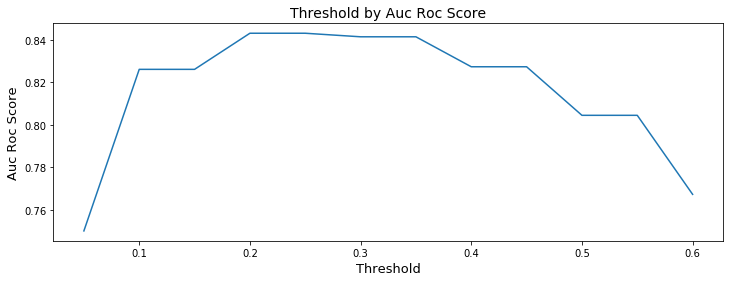

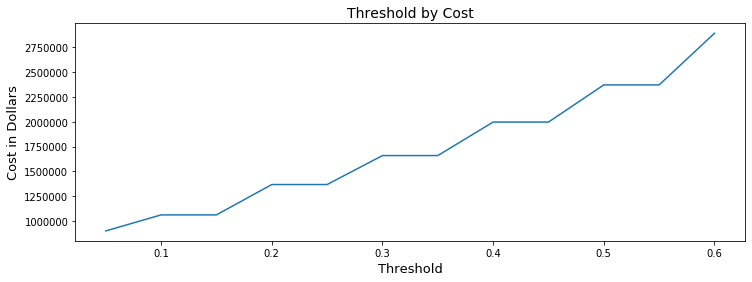

Best threshold by cost: 0.05
Best threshold by roc auc score: 0.2 

threshold results dataframe:
     threshold  roc_auc_score  total_cost   fn     fp
0        0.05       0.750144      901220  135  24811
1        0.10       0.826163     1062620  271  12481
2        0.15       0.826163     1062620  271  12481
3        0.20       0.843152     1368320  411   6766
4        0.25       0.843152     1368320  411   6766
5        0.30       0.841483     1659940  528   3797
6        0.35       0.841483     1659940  528   3797
7        0.40       0.827381     1997100  652   2055
8        0.45       0.827381     1997100  652   2055
9        0.50       0.804533     2371400  783   1120
10       0.55       0.804533     2371400  783   1120
11       0.60       0.767346     2891520  960    576

roc auc score: 0.843152254296433 

              precision    recall  f1-score   support

           0       0.99      0.88      0.93     56945
           1       0.20      0.81      0.32      2109

    accuracy 

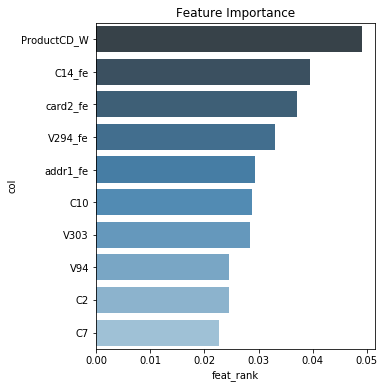

                  col  feat_rank
200       ProductCD_W   0.049027
280            C14_fe   0.039506
273          card2_fe   0.037107
278           V294_fe   0.033088
271          addr1_fe   0.029314
11                C10   0.028820
179              V303   0.028506
113               V94   0.024626
4                  C2   0.024615
8                  C7   0.022632
279           V279_fe   0.022604
12                C11   0.021843
70                V51   0.020366
275             C1_fe   0.019828
98                V79   0.019538
0       TransactionDT   0.017046
285           V317_fe   0.015173
1      TransactionAmt   0.014651
14                C13   0.013544
153              V134   0.012000
88                V69   0.011841
183              V308   0.011460
159              V282   0.011424
145              V126   0.011039
2               card1   0.010845
106               V87   0.010067
281           V306_fe   0.009170
164              V287   0.008660
9                  C8   0.008433
121       

In [485]:
# COMPLETE RandomForestClassifier - base
bool_predict_proba = True
model_current = RandomForestClassifier(n_jobs=-1, random_state=42, verbose=1)
mod.create_df_score_model(model_current)

Fitting model:
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


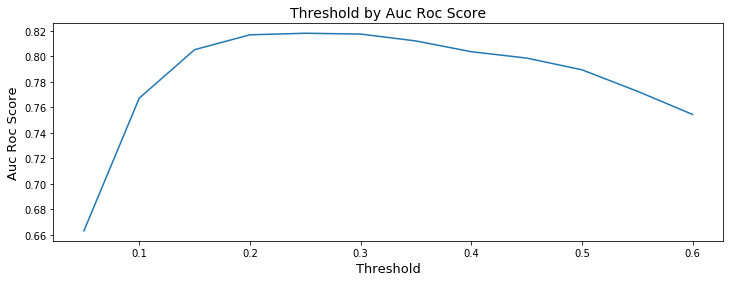

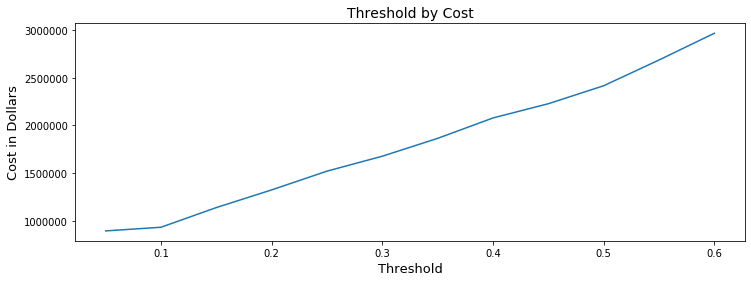

Best threshold by cost: 0.05
Best threshold by roc auc score: 0.25 

threshold results dataframe:
     threshold  roc_auc_score  total_cost   fn     fp
0        0.05       0.662981      895580   52  36979
1        0.10       0.767072      934000  164  22100
2        0.15       0.805125     1140060  283  14553
3        0.20       0.816776     1325080  369  10904
4        0.25       0.818014     1521520  450   8576
5        0.30       0.817381     1677940  513   6947
6        0.35       0.811963     1864940  584   5647
7        0.40       0.803533     2078480  663   4474
8        0.45       0.798545     2227600  719   3530
9        0.50       0.789352     2415820  787   2741
10       0.55       0.772554     2685320  881   2116
11       0.60       0.754307     2965500  978   1575

roc auc score: 0.8180136382251997 

              precision    recall  f1-score   support

           0       0.99      0.85      0.91     56945
           1       0.16      0.79      0.27      2109

    accurac

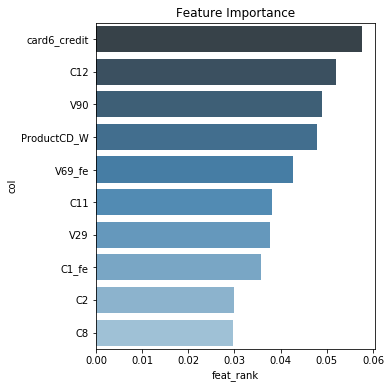

                             col  feat_rank
262                 card6_credit   0.057539
13                           C12   0.052076
109                          V90   0.049037
200                  ProductCD_W   0.047800
286                       V69_fe   0.042624
12                           C11   0.038017
48                           V29   0.037632
275                        C1_fe   0.035820
4                             C2   0.029793
9                             C8   0.029679
280                       C14_fe   0.028226
273                     card2_fe   0.025671
285                      V317_fe   0.025643
121                         V102   0.025444
122                         V103   0.023594
216      P_emaildomain_gmail.com   0.022893
116                          V97   0.022489
7                             C6   0.020965
159                         V282   0.020728
278                      V294_fe   0.020439
114                          V95   0.020035
157                         V280

In [486]:
# base XGBClassifier threshold
bool_predict_proba = True
model_current = XGBClassifier(random_state=42, n_jobs=-1)
mod.create_df_score_model(model_current)

Fitting model:
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

roc auc score: 0.7893515995673663 

              precision    recall  f1-score   support

           0       0.99      0.95      0.97     56945
           1       0.33      0.63      0.43      2109

    accuracy                           0.94     59054
   macro avg       0.66      0.79      0.70     59054
weighted avg       0.96      0.94      0.95     59054


df_scores:

     feat_tested   fn    fp  precision    recall  roc_auc_score  \
133         NaN  659  4408   0.247525  0.687530       0.805061   
13

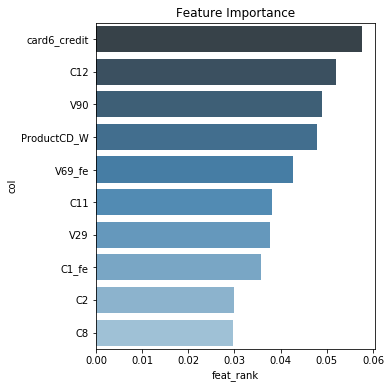

                             col  feat_rank
262                 card6_credit   0.057539
13                           C12   0.052076
109                          V90   0.049037
200                  ProductCD_W   0.047800
286                       V69_fe   0.042624
12                           C11   0.038017
48                           V29   0.037632
275                        C1_fe   0.035820
4                             C2   0.029793
9                             C8   0.029679
280                       C14_fe   0.028226
273                     card2_fe   0.025671
285                      V317_fe   0.025643
121                         V102   0.025444
122                         V103   0.023594
216      P_emaildomain_gmail.com   0.022893
116                          V97   0.022489
7                             C6   0.020965
159                         V282   0.020728
278                      V294_fe   0.020439
114                          V95   0.020035
157                         V280

In [487]:
# base XGBClassifier
bool_predict_proba = False
model_current = XGBClassifier(random_state=42, n_jobs=-1)
mod.create_df_score_model(model_current)

Fitting model:


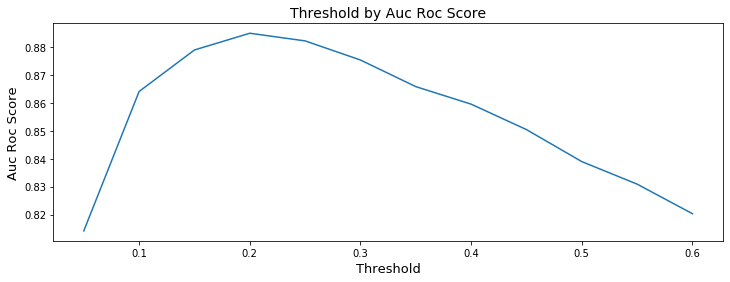

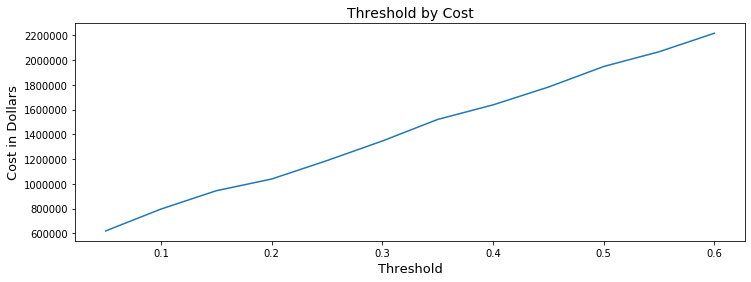

Best threshold by cost: 0.05
Best threshold by roc auc score: 0.2 

threshold results dataframe:
     threshold  roc_auc_score  total_cost   fn     fp
0        0.05       0.814153      620120   80  19006
1        0.10       0.864060      796720  198  10136
2        0.15       0.878925      944900  272   6445
3        0.20       0.884913     1039500  316   4575
4        0.25       0.882173     1188420  374   3321
5        0.30       0.875332     1346680  432   2534
6        0.35       0.865805     1520900  494   1945
7        0.40       0.859527     1638520  536   1526
8        0.45       0.850421     1782260  586   1213
9        0.50       0.838962     1948580  643    979
10       0.55       0.830901     2067800  684    790
11       0.60       0.820303     2217400  735    620

roc auc score: 0.8849126379129937 

              precision    recall  f1-score   support

           0       0.99      0.92      0.96     56945
           1       0.28      0.85      0.42      2109

    accuracy

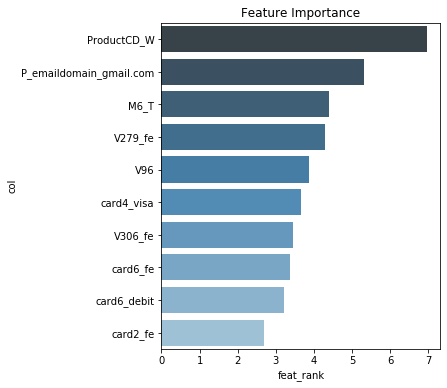

                         col  feat_rank
200              ProductCD_W   6.968368
216  P_emaildomain_gmail.com   5.301415
270                     M6_T   4.385852
279                  V279_fe   4.301050
115                      V96   3.870098
261               card4_visa   3.654619
281                  V306_fe   3.446131
277                 card6_fe   3.360541
263              card6_debit   3.213580
273                 card2_fe   2.699560
164                     V287   2.545501
260         card4_mastercard   2.448071
275                    C1_fe   2.433011
13                       C12   2.413523
4                         C2   2.127042
280                   C14_fe   1.855566
178                     V302   1.567747
278                  V294_fe   1.543546
31                       V12   1.534111
14                       C13   1.490212
48                       V29   1.482429
147                     V128   1.424545
285                  V317_fe   1.404979
276         P_emaildomain_fe   1.324148


In [488]:
# predict_proba CatBoostClassifier
bool_predict_proba = True
model_current = CatBoostClassifier(random_state=42, verbose=0)
mod.create_df_score_model(model_current)

# Model Class

In [468]:
class Model():
    def __init__(self):
        self.X_train = pd.DataFrame()
        self.y_train = pd.DataFrame()
        self.X_test = pd.DataFrame()
        self.y_test = pd.DataFrame()
        self.X_features = pd.DataFrame()
        self.y_target = pd.DataFrame()
        self.dict_results = {'index':[0], 'threshold':[], 'roc_auc_score':[], 
                             'total_cost':[], 'fn':[], 'fp':[]}
        self.X_train = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/X_train.csv').drop('Unnamed: 0',axis=1)
        self.y_train = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/y_train.csv').drop('Unnamed: 0',axis=1)
        self.X_test = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/X_test.csv').drop('Unnamed: 0',axis=1)
        self.y_test = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/y_test.csv').drop('Unnamed: 0',axis=1)
        self.X_features = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/X_features.csv').drop('Unnamed: 0',axis=1)
        self.y_target = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/y_target.csv').drop('Unnamed: 0',axis=1)
        
    def create_df_score_model(self, model):
        '''scores model'''
        print("Fitting model:\n", model)
        y_pred, elapsed_time, model = self.add_model(model) 
        df_scores, df_temp, y_pred = self._score_model(y_pred, elapsed_time)
        self._save_results(df_scores, df_temp, y_pred)
        self._feature_importance(model)
        fe.col_fe = []
        
    def add_model(self, model):        
        '''fitting model and calculating time elapsed'''
        start_time = time.time()
        model.fit(mod.X_train, mod.y_train)
        y_pred, model = self._predict(model)
        bool_predict_proba = False
        elapsed_time = (time.time() - start_time) / 60
        return y_pred, elapsed_time, model
    
    def _predict(self, model):
        '''make prediction'''
        if bool_predict_proba:
            print(model)
            y_pred, model = self._predict_proba(model)
            y_pred = self._predict_proba_threshold(y_pred)
            return y_pred, model
        else:
            y_pred = model.predict(mod.X_test)
            return y_pred, model
        
    def _predict_proba(self, model):
        try:
            y_pred_prob = model.predict_proba(mod.X_test)
            return y_pred_prob, model
        except:
            print("Model does not have predict_proba attribute.")

    def _predict_proba_threshold(self, y_pred):
        '''create prediction for each threshold'''
        df_results = pd.DataFrame()
        list_threshold = [.05, .1, .15, .2, .25, .3, 
                          .35, .4, .45, .5, .55, .6]
        for threshold in list_threshold:
            df_temp = self._compute_thres_df(y_pred, threshold)
            df_results = pd.concat([df_results, df_temp], axis=0)
        df_results = df_results.drop('index', axis=1).reset_index(drop=True)
        val_thres_cost, val_thres_auc = self._calc_and_plot_results(df_results)
        y_pred_class = self._y_pred_class(y_pred, val_thres_cost, val_thres_auc)
        print('threshold results dataframe:\n', df_results)
        return y_pred_class
        
    def _compute_thres_df(self, y_pred_prob, threshold):
        '''compute the values for each threshold'''
        y_pred_class = binarize(y_pred_prob, threshold)[:,1]
        df_conf_matrix = self._compute_conf_matrix(y_pred_class)
        df_dict_results = self._compute_results(df_conf_matrix, y_pred_class, threshold)
        return df_dict_results
    
    def _compute_conf_matrix(self, y_pred_class):
        '''compute the confusion matrix for the current threshold'''
        conf_matr = confusion_matrix(self.y_test, y_pred_class)
        df_conf_matrix = pd.DataFrame(conf_matr)
        return df_conf_matrix
    
    def _compute_results(self, df_conf_matrix, y_pred_class, threshold):
        '''compute results for each threshold and save to dictionary'''
        val_fn = df_conf_matrix[0][1]
        val_fp = df_conf_matrix[1][0]
        val_cost = 3000*val_fn + 20*val_fp
        val_score = roc_auc_score(self.y_test, y_pred_class)
        self.dict_results.update([('threshold', threshold)])
        self.dict_results.update([('roc_auc_score', val_score)])
        self.dict_results.update([('total_cost', val_cost)])
        self.dict_results.update([('fn', val_fn)])
        self.dict_results.update([('fp', val_fp)])
        df_dict_results = pd.DataFrame.from_dict(self.dict_results)
        return df_dict_results
    
    def _calc_and_plot_results(self, df_results):
        '''plot results and calculate best threshold for auc and cost'''
        self._plot_thres_auc(df_results)
        self._plot_thres_score(df_results)
        val_thres_cost = self._calc_best_thres_cost(df_results)
        val_thres_auc = self._calc_best_thres_auc(df_results)
        return val_thres_cost, val_thres_auc
        
    def _plot_thres_auc(self, df_results):
        '''plot auc roc score by threshold'''
        plt.figure(figsize=(12,4))
        plt.title("Threshold by Auc Roc Score", fontsize=14)
        plt.xlabel('Threshold', fontsize=13)
        plt.ylabel("Auc Roc Score", fontsize=13)
        plt.plot('threshold', 'roc_auc_score', data=df_results)
        plt.show()

    def _plot_thres_score(self, df_results):
        '''plot cost by threshold'''
        plt.figure(figsize=(12,4))
        plt.title("Threshold by Cost", fontsize=14)
        plt.xlabel('Threshold', fontsize=13)
        plt.ylabel("Cost in Dollars", fontsize=13)
        plt.plot('threshold', 'total_cost', data=df_results)
        plt.show()
    
    def _calc_best_thres_cost(self, df_results):
        '''calculate the best threshold by cost'''
        val_min_cost = df_results.total_cost.min()
        index_min_cost = df_results[df_results.total_cost==val_min_cost].index[0]
        val_threshold_min_cost = df_results.loc[index_min_cost,:].threshold.item()
        print("Best threshold by cost:", val_threshold_min_cost)
        return val_threshold_min_cost

    def _calc_best_thres_auc(self, df_results):
        '''calculate the best threshold by highest auc roc score'''
        val_max_roc_auc = df_results.roc_auc_score.max()
        index_max_roc_auc = df_results[df_results.roc_auc_score==val_max_roc_auc].index[0]
        val_threshold_roc_auc = df_results.loc[index_max_roc_auc,:].threshold.item()
        print("Best threshold by roc auc score:", val_threshold_roc_auc, '\n')
        return val_threshold_roc_auc
    
    def _y_pred_class(self, y_pred_prob, val_thres_cost, val_thres_auc):
        '''calculate y_pred_class depending on if we want cost or auc threshold'''
        if bool_thres_cost:
            y_pred_class = binarize(y_pred_prob, val_thres_cost)[:,1]
            return y_pred_class
        else:
            y_pred_class = binarize(y_pred_prob, val_thres_auc)[:,1]
            return y_pred_class

    def _score_model(self, y_pred, elapsed_time):      
        '''creating dataframe with score results'''
        col_recall, col_precision, col_time, col_auc = self._calc_scores(y_pred, 
                                                                         elapsed_time) 
        df_conf_matrix = self._confusion_matrix(y_pred)
        df_temp = pd.concat([col_auc, col_recall, col_precision, 
                             df_conf_matrix, col_time], axis=1)
        if fe.col_fe:
            df_temp = self._concat_new_feat(df_temp)
        df_scores = self._read_create_score_file(df_temp)
        return df_scores, df_temp, y_pred

    def _calc_scores(self, y_pred, elapsed_time):
        '''calculating recall, precision and elapsed time'''
        col_auc = pd.Series(roc_auc_score(mod.y_test, y_pred), name='roc_auc_score')
        col_recall = pd.Series(recall_score(mod.y_test, y_pred), name='recall')
        col_precision = pd.Series(precision_score(mod.y_test, y_pred), name='precision')
        col_time = pd.Series(elapsed_time, name='time_elapsed (min)')
        print('\nroc auc score:', roc_auc_score(mod.y_test, y_pred), '\n')
        return col_recall, col_precision, col_time, col_auc
    
    def _confusion_matrix(self, y_pred):
        '''creating confusion matrix dataframe'''
        df_conf_matrix = pd.DataFrame(confusion_matrix(mod.y_test, y_pred))
        val_tp = pd.Series(df_conf_matrix[0][0], name='tp')
        val_fn = pd.Series(df_conf_matrix[0][1], name='fn')
        val_fp = pd.Series(df_conf_matrix[1][0], name='fp')
        val_tn = pd.Series(df_conf_matrix[1][1], name='tn')
        return pd.concat([val_fn, val_fp, val_tp, val_tn], axis=1)

    def _concat_new_feat(self, df_temp):
        '''concatenate scoring results'''        
        print("\nThe following new features have been created:", fe.col_fe, '\n')
        if len(fe.col_fe) > 1: 
            fe.col_fe = "model score"
        col_fe = pd.Series(fe.col_fe, name='feat_tested')
        return pd.concat([col_fe, df_temp], axis=1)
    
    def _read_create_score_file(self, df_temp):
        '''reading or creating df_scores file'''
        try: 
            df_scores = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/df_scores.csv')
            df_scores = df_scores.drop('Unnamed: 0', axis=1)
        except:
            print("\nCreating df_scores.csv file.") 
            df_scores = df_temp
        return df_scores
            
    def _save_results(self, df_scores, df_temp, y_pred):
        '''printing scores for new features'''            
        df_scores = pd.concat([df_scores, df_temp], axis=0)
        df_scores.to_csv('/Users/krahman/work/fraud_detection/saved_files/df_scores.csv')
        classif_report = classification_report(mod.y_test, y_pred)
        self._print_summary(classif_report, df_scores)
        self._save_summary(classif_report)

    def _print_summary(self, classif_report, df_scores):
        '''print last 5 rows of previous score results'''
        print(classif_report)
        print('\ndf_scores:\n\n', df_scores.tail(5))
    
    def _save_summary(self, classif_report):
        '''save score result summary to text file'''
        file_summary = open('/Users/krahman/work/fraud_detection/saved_files/df_scores_summary.txt', "a")
        file_summary.write('New features created from: ' 
                           + fe.str_list_col_fe 
                           + '\n')
        file_summary.write(classif_report)
        file_summary.close()
        
    def _feature_importance(self, model):
        '''create feature importance dataframe and bar plot'''
        try:
            self._feat_import_method(model)
        except:
            print("\nmodel does not have _feature_importance attribute.")
    
    def _feat_import_method(self, model):
        '''run feature importance methods'''
        df_feat_rank = self._feat_import_create_df(model)
        df_feat_rank = self._feat_import_create_plot(df_feat_rank)
        
    def _feat_import_create_df(self, model):
        '''creating dataframe of important features'''
        col_name = pd.Series(mod.X_train.columns, name='col')
        col_feat_rank = pd.Series(model.feature_importances_, 
                                  name='feat_rank')
        df_feat_rank = pd.concat([col_name, col_feat_rank], axis=1)
        df_feat_rank = df_feat_rank.sort_values('feat_rank', ascending=False)
        return df_feat_rank
    
    def _feat_import_create_plot(self, df_feat_rank):
        '''create feature importance bar plot'''
        plt.figure(figsize=(5,6))
#         df_feat_rank = df_feat_rank[0:10] #del
        sns.barplot(df_feat_rank.feat_rank[0:10],
                    df_feat_rank.col[0:10],
                    palette='Blues_d')
        plt.title('Feature Importance')
        plt.show()
        print(df_feat_rank[0:60])
        
mod = Model()


In [ ]:
# max_depth = [2,3,5,7,9,11,13]
grow_policy = ['SymmetricTree', 'Depthwise', 'Lossguide']
for val in grow_policy:
    model_current = CatBoostClassifier(random_state=42, grow_policy=val, verbose=0)
    mod.create_df_score_model(model_current)

Fitting model:


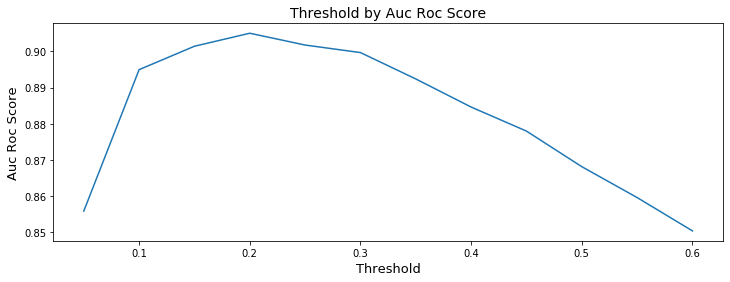

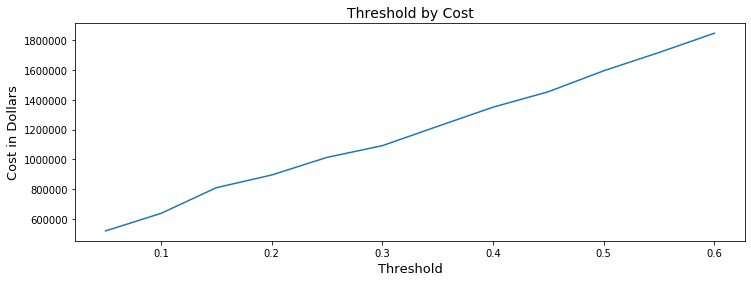

Best threshold by cost: 0.05
Best threshold by roc auc score: 0.2 

threshold results dataframe:
     threshold  roc_auc_score  total_cost   fn     fp
0        0.05       0.855851      520220   78  14311
1        0.10       0.894932      637840  162   7592
2        0.15       0.901403      810060  238   4803
3        0.20       0.904994      895360  276   3368
4        0.25       0.901736     1013480  321   2524
5        0.30       0.899655     1092020  351   1951
6        0.35       0.892367     1221780  397   1539
7        0.40       0.884604     1350160  442   1208
8        0.45       0.877957     1453860  478    993
9        0.50       0.868132     1594320  526    816
10       0.55       0.859597     1717080  568    654
11       0.60       0.850386     1846300  612    515

roc auc score: 0.9049937506767968 

              precision    recall  f1-score   support

           0       0.99      0.94      0.97     56945
           1       0.35      0.87      0.50      2109

    accuracy

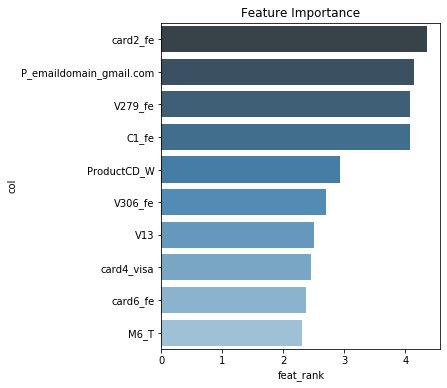

                         col  feat_rank
273                 card2_fe   4.357126
216  P_emaildomain_gmail.com   4.141132
279                  V279_fe   4.083325
275                    C1_fe   4.068268
200              ProductCD_W   2.921690
281                  V306_fe   2.700485
32                       V13   2.497189
261               card4_visa   2.456653
277                 card6_fe   2.373598
270                     M6_T   2.305032
2                      card1   2.292873
271                 addr1_fe   2.242551
260         card4_mastercard   2.229214
1             TransactionAmt   2.223650
0              TransactionDT   2.220868
116                      V97   2.189193
280                   C14_fe   2.125913
178                     V302   2.090323
14                       C13   1.996933
4                         C2   1.622870
147                     V128   1.447614
72                       V53   1.406842
285                  V317_fe   1.353306
12                       C11   1.334255


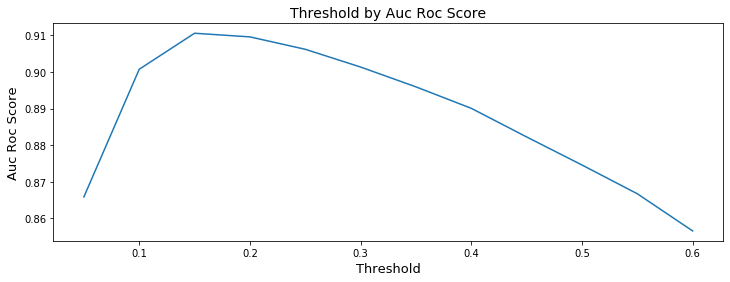

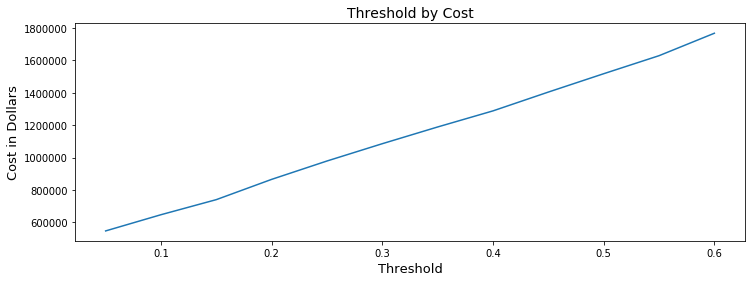

Best threshold by cost: 0.05
Best threshold by roc auc score: 0.15 

threshold results dataframe:
     threshold  roc_auc_score  total_cost   fn     fp
0        0.05       0.865861      546620   98  12631
1        0.10       0.900736      646760  171   6688
2        0.15       0.910579      739960  218   4298
3        0.20       0.909586      865220  268   3061
4        0.25       0.906196      978720  311   2286
5        0.30       0.901349     1085700  350   1785
6        0.35       0.895931     1189060  387   1403
7        0.40       0.890066     1288520  422   1126
8        0.45       0.882251     1404720  462    936
9        0.50       0.874585     1518120  501    756
10       0.55       0.866727     1629500  539    625
11       0.60       0.856567     1768260  586    513

roc auc score: 0.910578569382309 

              precision    recall  f1-score   support

           0       1.00      0.92      0.96     56945
           1       0.31      0.90      0.46      2109

    accuracy

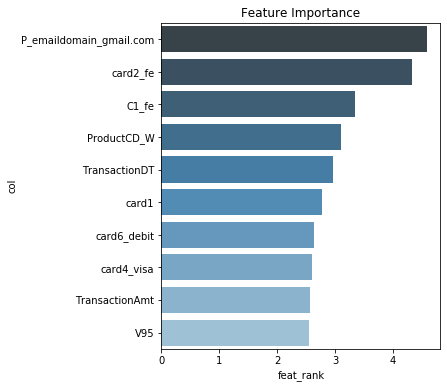

                         col  feat_rank
216  P_emaildomain_gmail.com   4.595238
273                 card2_fe   4.339117
275                    C1_fe   3.355730
200              ProductCD_W   3.103912
0              TransactionDT   2.961970
2                      card1   2.769082
263              card6_debit   2.637540
261               card4_visa   2.602392
1             TransactionAmt   2.562936
114                      V95   2.553395
4                         C2   2.518908
271                 addr1_fe   2.486951
280                   C14_fe   2.443601
14                       C13   2.381238
270                     M6_T   2.371785
281                  V306_fe   2.219906
260         card4_mastercard   1.844175
279                  V279_fe   1.708264
13                       C12   1.698296
285                  V317_fe   1.599145
54                       V35   1.457739
277                 card6_fe   1.457272
38                       V19   1.436008
157                     V280   1.428304


In [ ]:
max_depth = [9,10,11,12,13]
for val in max_depth:
    model_current = CatBoostClassifier(random_state=42, max_depth=val, verbose=0)
    mod.create_df_score_model(model_current)

In [ ]:
# base DecisionTreeClassifier
bool_predict_proba = False
model_current = DecisionTreeClassifier(random_state=42)
mod.create_df_score_model(model_current)

## Model Tuning

In [18]:
### Tuning XGBClassifier READY ###
print('tuning xgbc')
xgbc = XGBClassifier(n_jobs=-1, random_state=42)

max_depth = [2,3,5,7,9,11,13]
# learning_rate = [0,.1,.3,.5,.7,.9]
booster = ['gbtree', 'gblinear', 'dart']
subsample = [.1,.3,.5,.7]
colsample_bytree = [.1,.3,.5,.7]
colsample_bylevel = [0,.1,.3,.5,.7,.9,1]
colsample_bynode = [.1,.3,.5,.7]
reg_alpha = [0,1,3,5,7]
reg_lambda = [1,3,5,7]
scale_pos_weight = [1,3,5,7]
base_score = [.1,.2,.3,.4,.5]

hyperparameters = dict(max_depth=max_depth, 
#                        learning_rate=learning_rate, 
                       booster=booster, 
                       subsample=subsample, 
                       colsample_bytree=colsample_bytree, colsample_bylevel=colsample_bylevel, 
                       colsample_bynode=colsample_bynode, reg_alpha=reg_alpha, reg_lambda=reg_lambda, 
                       scale_pos_weight=scale_pos_weight,
                       base_score=base_score
                      )

clf = RandomizedSearchCV(xgbc, hyperparameters, random_state=42, cv=10, verbose=10, n_jobs=1, scoring='roc_auc')
best_model = clf.fit(mod.X_features, mod.y_target)

# best hyper parameters
print('Best max_depth:', best_model.best_estimator_.get_params()['max_depth'])
print('Best learning_rate:', best_model.best_estimator_.get_params()['learning_rate'])
print('Best booster:', best_model.best_estimator_.get_params()['booster'])
print('Best subsample:', best_model.best_estimator_.get_params()['subsample'])
print('Best colsample_bytree:', best_model.best_estimator_.get_params()['colsample_bytree'])
print('Best colsample_bylevel:', best_model.best_estimator_.get_params()['colsample_bylevel'])
print('Best colsample_bynode:', best_model.best_estimator_.get_params()['colsample_bynode'])
print('Best reg_alpha:', best_model.best_estimator_.get_params()['reg_alpha'])
print('Best reg_lambda:', best_model.best_estimator_.get_params()['reg_lambda'])
print('Best scale_pos_weight:', best_model.best_estimator_.get_params()['scale_pos_weight'])
print('Best base_score:', best_model.best_estimator_.get_params()['base_score'])
print(clf.best_estimator_)
pd.DataFrame(clf.cv_results_)


tuning xgbc
Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] subsample=0.5, scale_pos_weight=3, reg_lambda=5, reg_alpha=5, max_depth=9, colsample_bytree=0.5, colsample_bynode=0.7, colsample_bylevel=0.9, booster=dart, base_score=0.3 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  subsample=0.5, scale_pos_weight=3, reg_lambda=5, reg_alpha=5, max_depth=9, colsample_bytree=0.5, colsample_bynode=0.7, colsample_bylevel=0.9, booster=dart, base_score=0.3, score=0.987, total= 7.5min
[CV] subsample=0.5, scale_pos_weight=3, reg_lambda=5, reg_alpha=5, max_depth=9, colsample_bytree=0.5, colsample_bynode=0.7, colsample_bylevel=0.9, booster=dart, base_score=0.3 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.5min remaining:    0.0s


[CV]  subsample=0.5, scale_pos_weight=3, reg_lambda=5, reg_alpha=5, max_depth=9, colsample_bytree=0.5, colsample_bynode=0.7, colsample_bylevel=0.9, booster=dart, base_score=0.3, score=0.986, total= 6.9min
[CV] subsample=0.5, scale_pos_weight=3, reg_lambda=5, reg_alpha=5, max_depth=9, colsample_bytree=0.5, colsample_bynode=0.7, colsample_bylevel=0.9, booster=dart, base_score=0.3 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 14.4min remaining:    0.0s


[CV]  subsample=0.5, scale_pos_weight=3, reg_lambda=5, reg_alpha=5, max_depth=9, colsample_bytree=0.5, colsample_bynode=0.7, colsample_bylevel=0.9, booster=dart, base_score=0.3, score=0.987, total= 6.9min
[CV] subsample=0.5, scale_pos_weight=3, reg_lambda=5, reg_alpha=5, max_depth=9, colsample_bytree=0.5, colsample_bynode=0.7, colsample_bylevel=0.9, booster=dart, base_score=0.3 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 21.3min remaining:    0.0s


[CV]  subsample=0.5, scale_pos_weight=3, reg_lambda=5, reg_alpha=5, max_depth=9, colsample_bytree=0.5, colsample_bynode=0.7, colsample_bylevel=0.9, booster=dart, base_score=0.3, score=0.985, total= 6.9min
[CV] subsample=0.5, scale_pos_weight=3, reg_lambda=5, reg_alpha=5, max_depth=9, colsample_bytree=0.5, colsample_bynode=0.7, colsample_bylevel=0.9, booster=dart, base_score=0.3 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 28.2min remaining:    0.0s


[CV]  subsample=0.5, scale_pos_weight=3, reg_lambda=5, reg_alpha=5, max_depth=9, colsample_bytree=0.5, colsample_bynode=0.7, colsample_bylevel=0.9, booster=dart, base_score=0.3, score=0.987, total= 6.0min
[CV] subsample=0.5, scale_pos_weight=3, reg_lambda=5, reg_alpha=5, max_depth=9, colsample_bytree=0.5, colsample_bynode=0.7, colsample_bylevel=0.9, booster=dart, base_score=0.3 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 34.2min remaining:    0.0s


[CV]  subsample=0.5, scale_pos_weight=3, reg_lambda=5, reg_alpha=5, max_depth=9, colsample_bytree=0.5, colsample_bynode=0.7, colsample_bylevel=0.9, booster=dart, base_score=0.3, score=0.988, total= 6.2min
[CV] subsample=0.5, scale_pos_weight=3, reg_lambda=5, reg_alpha=5, max_depth=9, colsample_bytree=0.5, colsample_bynode=0.7, colsample_bylevel=0.9, booster=dart, base_score=0.3 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 40.4min remaining:    0.0s


[CV]  subsample=0.5, scale_pos_weight=3, reg_lambda=5, reg_alpha=5, max_depth=9, colsample_bytree=0.5, colsample_bynode=0.7, colsample_bylevel=0.9, booster=dart, base_score=0.3, score=0.987, total= 6.3min
[CV] subsample=0.5, scale_pos_weight=3, reg_lambda=5, reg_alpha=5, max_depth=9, colsample_bytree=0.5, colsample_bynode=0.7, colsample_bylevel=0.9, booster=dart, base_score=0.3 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 46.7min remaining:    0.0s


[CV]  subsample=0.5, scale_pos_weight=3, reg_lambda=5, reg_alpha=5, max_depth=9, colsample_bytree=0.5, colsample_bynode=0.7, colsample_bylevel=0.9, booster=dart, base_score=0.3, score=0.987, total= 6.3min
[CV] subsample=0.5, scale_pos_weight=3, reg_lambda=5, reg_alpha=5, max_depth=9, colsample_bytree=0.5, colsample_bynode=0.7, colsample_bylevel=0.9, booster=dart, base_score=0.3 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 53.0min remaining:    0.0s


[CV]  subsample=0.5, scale_pos_weight=3, reg_lambda=5, reg_alpha=5, max_depth=9, colsample_bytree=0.5, colsample_bynode=0.7, colsample_bylevel=0.9, booster=dart, base_score=0.3, score=0.987, total= 6.4min
[CV] subsample=0.5, scale_pos_weight=3, reg_lambda=5, reg_alpha=5, max_depth=9, colsample_bytree=0.5, colsample_bynode=0.7, colsample_bylevel=0.9, booster=dart, base_score=0.3 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 59.4min remaining:    0.0s


[CV]  subsample=0.5, scale_pos_weight=3, reg_lambda=5, reg_alpha=5, max_depth=9, colsample_bytree=0.5, colsample_bynode=0.7, colsample_bylevel=0.9, booster=dart, base_score=0.3, score=0.988, total= 6.6min
[CV] subsample=0.7, scale_pos_weight=1, reg_lambda=7, reg_alpha=7, max_depth=11, colsample_bytree=0.7, colsample_bynode=0.1, colsample_bylevel=0, booster=dart, base_score=0.4 
[CV]  subsample=0.7, scale_pos_weight=1, reg_lambda=7, reg_alpha=7, max_depth=11, colsample_bytree=0.7, colsample_bynode=0.1, colsample_bylevel=0, booster=dart, base_score=0.4, score=0.966, total= 2.6min
[CV] subsample=0.7, scale_pos_weight=1, reg_lambda=7, reg_alpha=7, max_depth=11, colsample_bytree=0.7, colsample_bynode=0.1, colsample_bylevel=0, booster=dart, base_score=0.4 
[CV]  subsample=0.7, scale_pos_weight=1, reg_lambda=7, reg_alpha=7, max_depth=11, colsample_bytree=0.7, colsample_bynode=0.1, colsample_bylevel=0, booster=dart, base_score=0.4, score=0.964, total= 2.6min
[CV] subsample=0.7, scale_pos_weigh

[CV]  subsample=0.5, scale_pos_weight=7, reg_lambda=1, reg_alpha=5, max_depth=9, colsample_bytree=0.7, colsample_bynode=0.7, colsample_bylevel=1, booster=gblinear, base_score=0.5, score=0.796, total= 1.6min
[CV] subsample=0.5, scale_pos_weight=7, reg_lambda=1, reg_alpha=5, max_depth=9, colsample_bytree=0.7, colsample_bynode=0.7, colsample_bylevel=1, booster=gblinear, base_score=0.5 
[CV]  subsample=0.5, scale_pos_weight=7, reg_lambda=1, reg_alpha=5, max_depth=9, colsample_bytree=0.7, colsample_bynode=0.7, colsample_bylevel=1, booster=gblinear, base_score=0.5, score=0.804, total= 1.6min
[CV] subsample=0.5, scale_pos_weight=7, reg_lambda=1, reg_alpha=5, max_depth=9, colsample_bytree=0.7, colsample_bynode=0.7, colsample_bylevel=1, booster=gblinear, base_score=0.5 
[CV]  subsample=0.5, scale_pos_weight=7, reg_lambda=1, reg_alpha=5, max_depth=9, colsample_bytree=0.7, colsample_bynode=0.7, colsample_bylevel=1, booster=gblinear, base_score=0.5, score=0.802, total= 1.7min
[CV] subsample=0.5, s

[CV]  subsample=0.7, scale_pos_weight=3, reg_lambda=1, reg_alpha=7, max_depth=9, colsample_bytree=0.7, colsample_bynode=0.1, colsample_bylevel=0.9, booster=gbtree, base_score=0.3, score=0.984, total= 2.4min
[CV] subsample=0.7, scale_pos_weight=3, reg_lambda=1, reg_alpha=7, max_depth=9, colsample_bytree=0.7, colsample_bynode=0.1, colsample_bylevel=0.9, booster=gbtree, base_score=0.3 
[CV]  subsample=0.7, scale_pos_weight=3, reg_lambda=1, reg_alpha=7, max_depth=9, colsample_bytree=0.7, colsample_bynode=0.1, colsample_bylevel=0.9, booster=gbtree, base_score=0.3, score=0.986, total=14.8min
[CV] subsample=0.7, scale_pos_weight=3, reg_lambda=1, reg_alpha=7, max_depth=9, colsample_bytree=0.7, colsample_bynode=0.1, colsample_bylevel=0.9, booster=gbtree, base_score=0.3 
[CV]  subsample=0.7, scale_pos_weight=3, reg_lambda=1, reg_alpha=7, max_depth=9, colsample_bytree=0.7, colsample_bynode=0.1, colsample_bylevel=0.9, booster=gbtree, base_score=0.3, score=0.987, total= 2.6min
[CV] subsample=0.7, s

[CV]  subsample=0.1, scale_pos_weight=3, reg_lambda=3, reg_alpha=0, max_depth=13, colsample_bytree=0.5, colsample_bynode=0.3, colsample_bylevel=1, booster=dart, base_score=0.1, score=0.987, total= 4.3min
[CV] subsample=0.1, scale_pos_weight=3, reg_lambda=3, reg_alpha=0, max_depth=13, colsample_bytree=0.5, colsample_bynode=0.3, colsample_bylevel=1, booster=dart, base_score=0.1 
[CV]  subsample=0.1, scale_pos_weight=3, reg_lambda=3, reg_alpha=0, max_depth=13, colsample_bytree=0.5, colsample_bynode=0.3, colsample_bylevel=1, booster=dart, base_score=0.1, score=0.986, total= 4.4min
[CV] subsample=0.1, scale_pos_weight=3, reg_lambda=3, reg_alpha=0, max_depth=13, colsample_bytree=0.5, colsample_bynode=0.3, colsample_bylevel=1, booster=dart, base_score=0.1 
[CV]  subsample=0.1, scale_pos_weight=3, reg_lambda=3, reg_alpha=0, max_depth=13, colsample_bytree=0.5, colsample_bynode=0.3, colsample_bylevel=1, booster=dart, base_score=0.1, score=0.987, total= 4.5min
[CV] subsample=0.1, scale_pos_weight

[CV]  subsample=0.3, scale_pos_weight=5, reg_lambda=7, reg_alpha=5, max_depth=7, colsample_bytree=0.3, colsample_bynode=0.3, colsample_bylevel=1, booster=dart, base_score=0.3, score=0.984, total= 2.8min
[CV] subsample=0.3, scale_pos_weight=5, reg_lambda=7, reg_alpha=5, max_depth=7, colsample_bytree=0.3, colsample_bynode=0.3, colsample_bylevel=1, booster=dart, base_score=0.3 
[CV]  subsample=0.3, scale_pos_weight=5, reg_lambda=7, reg_alpha=5, max_depth=7, colsample_bytree=0.3, colsample_bynode=0.3, colsample_bylevel=1, booster=dart, base_score=0.3, score=0.983, total= 2.8min
[CV] subsample=0.3, scale_pos_weight=5, reg_lambda=7, reg_alpha=5, max_depth=7, colsample_bytree=0.3, colsample_bynode=0.3, colsample_bylevel=1, booster=dart, base_score=0.3 
[CV]  subsample=0.3, scale_pos_weight=5, reg_lambda=7, reg_alpha=5, max_depth=7, colsample_bytree=0.3, colsample_bynode=0.3, colsample_bylevel=1, booster=dart, base_score=0.3, score=0.984, total= 2.8min


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 315.8min finished


Best max_depth: 13
Best learning_rate: 0.1
Best booster: gbtree
Best subsample: 0.5
Best colsample_bytree: 0.7
Best colsample_bylevel: 0.3
Best colsample_bynode: 0.5
Best reg_alpha: 3
Best reg_lambda: 5
Best scale_pos_weight: 5
Best base_score: 0.4


In [19]:
print(clf.best_estimator_)
pd.DataFrame(clf.cv_results_)

XGBClassifier(base_score=0.4, booster='gbtree', colsample_bylevel=0.3,
              colsample_bynode=0.5, colsample_bytree=0.7, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=13,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=3, reg_lambda=5, scale_pos_weight=5, seed=None,
              silent=None, subsample=0.5, verbosity=1)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_scale_pos_weight,param_reg_lambda,param_reg_alpha,param_max_depth,param_colsample_bytree,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,395.304133,25.412146,0.587299,0.052609,0.5,3,5,5,9,0.5,...,0.985380,0.986789,0.987938,0.986694,0.987347,0.986711,0.987547,0.986829,0.000743,2
1,167.217239,11.165350,0.489047,0.155241,0.7,1,7,7,11,0.7,...,0.963229,0.964751,0.967276,0.963401,0.966066,0.964305,0.966658,0.965024,0.001343,7
2,120.322799,8.478442,0.271042,0.108111,0.1,7,3,7,2,0.7,...,0.961926,0.962940,0.965645,0.961338,0.963113,0.962412,0.964037,0.963005,0.001308,8
3,99.684576,5.295310,0.226211,0.090092,0.5,7,1,5,9,0.7,...,0.802181,0.798554,0.805074,0.801674,0.804025,0.797907,0.806804,0.801659,0.003228,10
4,203.073417,25.312860,0.677408,0.173201,0.5,5,5,3,13,0.7,...,0.987628,0.988995,0.989606,0.988777,0.989180,0.988744,0.989257,0.988861,0.000556,1
5,217.663624,223.572931,0.553119,0.219257,0.7,3,1,7,9,0.7,...,0.984488,0.985504,0.986885,0.985129,0.985695,0.984936,0.986337,0.985598,0.000679,4
6,103.800450,5.746303,0.394553,0.301245,0.1,7,7,3,3,0.3,...,0.959114,0.960575,0.963978,0.959773,0.963111,0.959996,0.962418,0.961344,0.001475,9
7,305.320971,59.342621,0.606575,0.120821,0.1,3,3,0,13,0.5,...,0.985453,0.986445,0.987005,0.985547,0.986576,0.985673,0.987112,0.986233,0.000623,3
8,102.538558,3.363380,0.421863,0.036955,0.5,3,5,7,11,0.1,...,0.982312,0.983491,0.984753,0.982607,0.983767,0.982724,0.984011,0.983344,0.000777,5
9,173.911546,5.071884,0.338486,0.032476,0.3,5,7,5,7,0.3,...,0.982008,0.983266,0.984789,0.982414,0.983546,0.982560,0.983857,0.983167,0.000871,6


In [ ]:
###### testing manual tuning ######
### manual xbgc tuning
max_depth = [3,5,7,9,11,13,15]
# max_depth = [1,3,5]
list_time_elapsed = []
list_roc_auc_score = []
for val in max_depth:
    model_xgbc = XGBClassifier(max_depth=val, n_jobs=-1, random_state=42)
    
    start_time = time.time()
    model_xgbc.fit(mod.X_train_test, mod.y_train)
    y_pred_xgbc = model_xgbc.predict(mod.X_test)
    elapsed_time = (time.time() - start_time) / 60
    
    score_roc_auc = roc_auc_score(mod.y_test, y_pred_xgbc)

    list_time_elapsed.append(elapsed_time)
    list_roc_auc_score.append(score_roc_auc)
    print('max depth: ', val)
    print(confusion_matrix(mod.y_test, y_pred_xgbc))

col_time_elapsed = pd.Series(list_time_elapsed)
col_roc_score = pd.Series(list_roc_auc_score)
col_max_depth = pd.Series(max_depth)
df_results_xgbc = pd.concat([col_max_depth, col_roc_score,col_time_elapsed], 
                            keys=['max_depth', 'roc_auc_score', 'time_elap'], 
                            axis=1)
print(df_results_xgbc)

sns.lineplot(x='max_depth', y='roc_auc_score', data=df_results_xgbc)
plt.title("XGBC manual tuning")
plt.show()

In [ ]:
#### Tuning RandomForestClassifier READY ####
rfc = RandomForestClassifier(oob_score=False, n_jobs=1, random_state=42, verbose=1)

n_estimators = [50,75,100,125,150,200]
criterion = ['gini', 'entropy']
max_depth = [3,5,7,9,11,13,15]
min_samples_split = [2,3,5,7,9]
min_samples_leaf = [1,2,4,6,8,10]
min_weight_fraction_leaf = [0,.1,.2,.3,.4,.5]
max_features = ['auto', 'sqrt', 'log2', None]
max_leaf_nodes = [2,3,5,7,9,None]
min_impurity_decrease = [0,.1,.3,.5,.7,.9]

hyperparameters = dict(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, 
                       min_samples_split=min_samples_split,
                       min_samples_leaf=min_samples_leaf, min_weight_fraction_leaf=min_weight_fraction_leaf,
                       max_features=max_features, max_leaf_nodes=max_leaf_nodes,
                       min_impurity_decrease=min_impurity_decrease
                      )

clf = RandomizedSearchCV(rfc, hyperparameters, random_state=42, cv=5, verbose=5, n_jobs=1, scoring='roc_auc')
best_model = clf.fit(mod.X_features, mod.y_target)

# best hyper parameters
print('Best n_estimators:', best_model.best_estimator_.get_params()['n_estimators'])
print('Best criterion:', best_model.best_estimator_.get_params()['criterion'])
print('Best max_depth:', best_model.best_estimator_.get_params()['max_depth'])
print('Best min_samples_split:', best_model.best_estimator_.get_params()['min_samples_split'])
print('Best min_samples_leaf:', best_model.best_estimator_.get_params()['min_samples_leaf'])
print('Best min_weight_fraction_leaf:', best_model.best_estimator_.get_params()['min_weight_fraction_leaf'])
print('Best max_features:', best_model.best_estimator_.get_params()['max_features'])
print('Best max_leaf_nodes:', best_model.best_estimator_.get_params()['max_leaf_nodes'])
print('Best min_impurity_decrease:', best_model.best_estimator_.get_params()['min_impurity_decrease'])
print(clf.best_estimator_)
pd.DataFrame(clf.cv_results_)


In [191]:
#### LR Tuning ####
lr = LogisticRegression(random_state=42, n_jobs=-1)

penalty = ['l1', 'l2', 'elasticnet','none']
tol = [1e-1,1e-2,1e-3,1e-4,1e-5,1e-6,1e-7]
C = [1e-1,.2,.3,.5,.7,1]
fit_intercept = [True,False]
intercept_scaling = [1,.1,.01,.001]
class_weight = ['balanced', None]
solver = ['newton-cg', 'lbfgs', 'sag']#, 'liblinear','saga']
max_iter = [50,75,100,150,200]
multi_class = ['auto', 'ovr', 'multinomial']
l1_ratio = [1e-1,1e-2,1e-3,1e-4,1e-5,1e-6,1e-7]


hyperparameters = dict(penalty=penalty, 
#                        tol=tol, 
#                        C=C, 
#                        fit_intercept=fit_intercept,
                       intercept_scaling=intercept_scaling, 
                       class_weight=class_weight,
                       solver=solver, 
#                        max_iter=max_iter
                       multi_class=multi_class, 
                       l1_ratio=l1_ratio
                      )

clf = RandomizedSearchCV(lr, hyperparameters, random_state=42, cv=10, verbose=10, n_jobs=1, scoring='roc_auc')
best_model = clf.fit(mod.X_features, mod.y_target)
# best_model = clf.fit(mod.X_features_test, mod.y_target_test) #testing

# best hyper parameters
print('Best penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best tol:', best_model.best_estimator_.get_params()['tol'])
print('Best C:', best_model.best_estimator_.get_params()['C'])
print('Best fit_intercept:', best_model.best_estimator_.get_params()['fit_intercept'])
print('Best intercept_scaling:', best_model.best_estimator_.get_params()['intercept_scaling'])
print('Best class_weight:', best_model.best_estimator_.get_params()['class_weight'])
print('Best solver:', best_model.best_estimator_.get_params()['solver'])
print('Best max_iter:', best_model.best_estimator_.get_params()['max_iter'])
print('Best multi_class:', best_model.best_estimator_.get_params()['multi_class'])
print('Best l1_ratio:', best_model.best_estimator_.get_params()['l1_ratio'])
print(clf.best_estimator_)
pd.DataFrame(clf.cv_results_)


In [ ]:
#### Tuning DTC READY ####
dt = DecisionTreeClassifier(random_state=42, n_jobs=-1)

criterion = ['gini', 'entropy']
splitter = ['best', 'random']
max_depth = [3,5,7,9,11]
min_samples_split = [2,3,5,7,9]
min_samples_leaf = [1,3,5,7,9]
min_weight_fraction_leaf = [0,.1,.2,.3,.4,.5]
max_features = ['auto', 'sqrt', 'log2', None]
class_weight = ['balanced', None]

hyperparameters = dict(criterion=criterion, splitter=splitter, max_depth=max_depth, 
                       min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, 
                       min_weight_fraction_leaf=min_weight_fraction_leaf,
                       max_features=max_features, class_weight=class_weight
                      )

clf = RandomizedSearchCV(dt, hyperparameters, random_state=42, cv=10, verbose=10, n_jobs=1, scoring='roc_auc')
best_model = clf.fit(mod.X_features, mod.y_target)
# best_model = clf.fit(mod.X_features_test, mod.y_target_test) #testing
 
# best hyper parameters
print('Best criterion:', best_model.best_estimator_.get_params()['criterion'])
print('Best splitter:', best_model.best_estimator_.get_params()['splitter'])
print('Best max_depth:', best_model.best_estimator_.get_params()['max_depth'])
print('Best min_samples_split:', best_model.best_estimator_.get_params()['min_samples_split'])
print('Best min_samples_leaf:', best_model.best_estimator_.get_params()['min_samples_leaf'])
print('Best min_weight_fraction_leaf:', best_model.best_estimator_.get_params()['min_weight_fraction_leaf'])
print('Best max_features:', best_model.best_estimator_.get_params()['max_features'])
print('Best class_weight:', best_model.best_estimator_.get_params()['class_weight'])
print(clf.best_estimator_)
pd.DataFrame(clf.cv_results_)


In [ ]:
### Tuning CatBoost READY ###
# Tune learning rate manually.
cbc = CatBoostClassifier(random_state=42)

max_depth = [2,3,5,7,9,11,13]
learning_rate = [.1,.3,.5,.7,.9]
# bagging_temperature = []
subsample = [1,3,5,7]
n_estimators = [50,75,100,150]
depth = [2,4,6,8,10]
grow_policy = ['SymmetricTree', 'Depthwise', 'Lossguide']


hyperparameters = dict(
#                         max_depth=max_depth, 
#                        learning_rate=learning_rate, 
#                        n_estimators=n_estimators,
                       subsample=subsample,
#                        depth=depth,
                       grow_policy=grow_policy
                      )

clf = RandomizedSearchCV(cbc, hyperparameters, random_state=42, cv=10, verbose=10, n_jobs=1, scoring='roc_auc')
best_model = clf.fit(mod.X_features, mod.y_target)

# best hyper parameters
print('Best max_depth:', best_model.best_estimator_.get_params()['max_depth'])
print('Best learning_rate:', best_model.best_estimator_.get_params()['learning_rate'])
print('Best n_estimators:', best_model.best_estimator_.get_params()['n_estimators'])
print('Best subsample:', best_model.best_estimator_.get_params()['subsample'])
print(clf.best_estimator_)
pd.DataFrame(clf.cv_results_)



In [196]:
df_temp_read = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/df_scores.csv')
df_temp_read = df_temp_read.drop('Unnamed: 0', axis=1)
# df_temp_read[len(df_temp_read)-40:]
df_temp_read

,roc_auc_score,recall,precision,fn,fp,tp,tn,time_elapsed (min)
0,0.805061,0.68753,0.247525,659,4408,52537,1450,0.545381
1,0.805061,0.68753,0.247525,659,4408,52537,1450,0.545381
